# Figure: Cal beads simulation

Neerja Aggarwal
May 20th, 2024
Purpose: simulate measurement and reconstruction from different optical configurations.


## Import

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import os
import sys

gpu = 3

# ACTION: CHOOSE WHICH GPU TO USE (0-3)
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_LAUNCH_BLOCKING'] = str(1) # get more error messages
# ACTION: CHOOSE WHICH GPU TO USE (0-3)
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false' #stop jax from preallocating 75% of the gpu
sys.path.append('../../ReconCode')
try:
    import sdc_jax as sdc
    print("Successfully imported sdc_jax")
except ImportError as e:
    print(f"Error importing sdc_jax: {e}")

import jax.numpy as jnp
import jax
import optax
# figures helper functions
%run figures_util.py
# from cleanplots import *

# %load_ext autoreload
# %autoreload 2
# import os
# import sys  

Successfully imported sdc_jax


## System Parameters

In [2]:
# choose this so we get 64 total wavelength channels from 388 to ~390.  8 nm step works well. 
wvmin = 388
wvmax = 890
wvstep =8 
# wvmin = 450
# wvmax = 800
# wvstep = 6

downsample_factor = 1
wavelengths = np.arange(wvmin,wvmax+wvstep,wvstep)

mag_size = 10*9/39 # 4x followed by diffuser
spectral_camera_pixel_size = 2.4 # um
recon_pixel_size = spectral_camera_pixel_size*downsample_factor
gt_pixel_size = 4.4 # um
gt_mag_size = 10*0.38 # 4x followed by 0.38x tube lens
superpixel_size = 160 # um

print(len(wavelengths))

64


## Choose calibration data

### 1. Make ideal filter

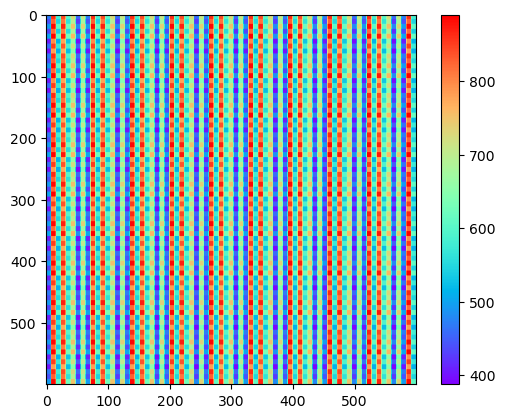

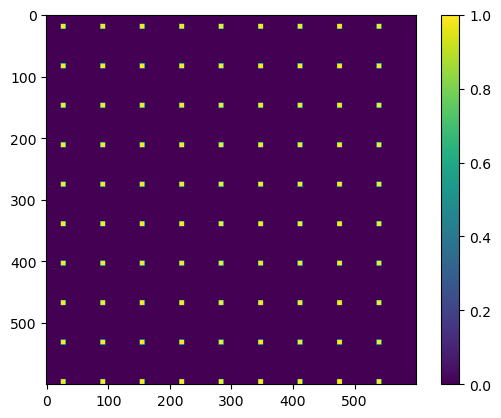

In [3]:
# use idealized filter array instead

cmap_rainbow = plt.get_cmap('rainbow')
colors = cmap_rainbow(np.linspace(0, 1, len(wavelengths)))
tiled_peak_wavelength = np.load('tiled_peak_wavelength.npy')
peak_wv = np.unique(tiled_peak_wavelength)

shape_3d = (len(wavelengths), *tiled_peak_wavelength.shape)
spectral_filter_ideal = np.zeros(shape_3d, dtype = int)
    # Populate the 3D matrix
for i in range(tiled_peak_wavelength.shape[0]):
    for j in range(tiled_peak_wavelength.shape[1]):
        # Find the index of the closest wavelength
        wavelength_value = tiled_peak_wavelength[i, j]
        # find the index in peak_wv
        if len(wavelengths)==64: #if there are only 64 recon channels, then just assign filters to channels
            index = np.where(peak_wv == wavelength_value)[0][0]
        else: #try to find the right filter for each wavelength channel. 
            index = np.argmin(np.abs(wavelengths - wavelength_value))
        spectral_filter_ideal[index, i, j] = 1
plt.figure()
plt.imshow(tiled_peak_wavelength, cmap = cmap_rainbow)
plt.colorbar()
# plt.axis('off')

plt.figure()
plt.imshow(spectral_filter_ideal[60,:,:])
plt.colorbar()

#add offset
offset_perc = 1e-2
spectral_filter = spectral_filter_ideal + offset_perc*np.amax(spectral_filter_ideal)
(dim0,dim1,dim2) = spectral_filter.shape
crop_indices = [0,dim1,0,dim2]
normalized_filter_cube =  spectral_filter_ideal

# Create a folder for the measurements and psfs
measurement_folder = 'sim_data_ideal_offset'


In [4]:
# save the spectral filter cube 
calibration_location = '../Calibration_data'
filter_cube_file = 'spectral_filter_ideal_2025-04-23.npy'
calibration_wavelengths_file = 'wavelengths_2025-04-23.npy'

# Save the spectral filter and wavelengths to the specified files
np.save(os.path.join(calibration_location, filter_cube_file), spectral_filter)
np.save(os.path.join(calibration_location, calibration_wavelengths_file), wavelengths)


optional: load spectral transmission data cube from experiment

In [5]:
# calibration_location = '../Calibration_data'
# calibration_wavelengths_file = 'wavelengths_2024-02-23.npy'
# filter_cube_file = 'spectral_filter_2024-02-23.npy'
# crop_indices = [600,1200,1400,2000] #top bottom left right
# # Load and crop filter cube if want to use instead of ideal
# wv = np.load(os.path.join(calibration_location,calibration_wavelengths_file))
# normalized_filter_cube = jnp.load(os.path.join(calibration_location, filter_cube_file))
# filterstack = sdc.cropci(normalized_filter_cube, crop_indices)
# msum = sdc.sumFilterArray(filterstack, wv,wvmin,wvmax,wvstep)
# spectral_filter = msum / jnp.amax(msum)
# spectral_filter = spectral_filter - jnp.amin(spectral_filter, axis=0, keepdims=True)[0]
# (dim0,dim1,dim2) = spectral_filter.shape


### 2. Load PSF

In [6]:
calibration_location = '../Calibration_data'
psf_name = 'psf_2024-04-22.npy'

# Load and crop PSF
sensor_psf = jnp.load(os.path.join(calibration_location, psf_name))
psf = sdc.center_crop(sensor_psf, spectral_filter.shape[1:])
psf = psf / jnp.sum(psf)
psf = psf.clip(0)


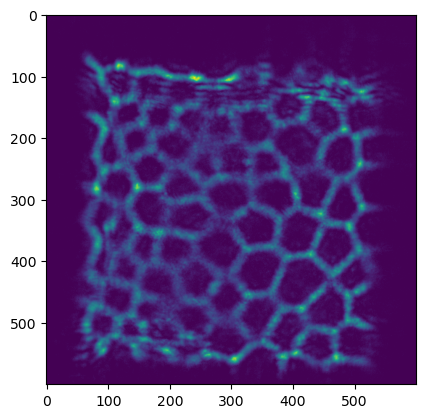

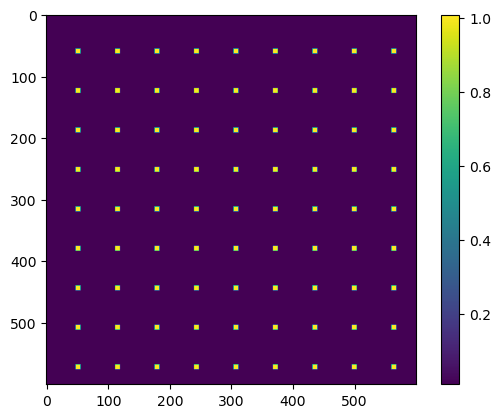

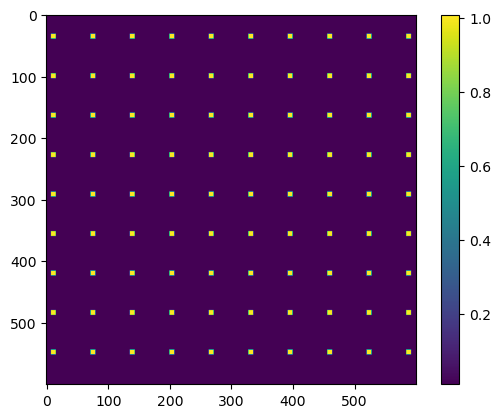

In [7]:
plt.figure()
plt.imshow(psf)
xk = jnp.zeros_like(spectral_filter)
padding = (
    (0, 0, 0),
    (np.ceil(xk.shape[1] / 2).astype(int), np.floor(xk.shape[1] / 2).astype(int), 0),
    (np.ceil(xk.shape[2] / 2).astype(int), np.floor(xk.shape[2] / 2).astype(int), 0),
)
hpad = jax.lax.pad(psf[None, ...], 0.0, padding).squeeze()
hfftpad = jnp.fft.fft2(hpad)

plt.figure()
plt.imshow(spectral_filter[0,:,:])
plt.colorbar()

plt.figure()
plt.imshow(spectral_filter[-1,:,:])
plt.colorbar()

## Make object

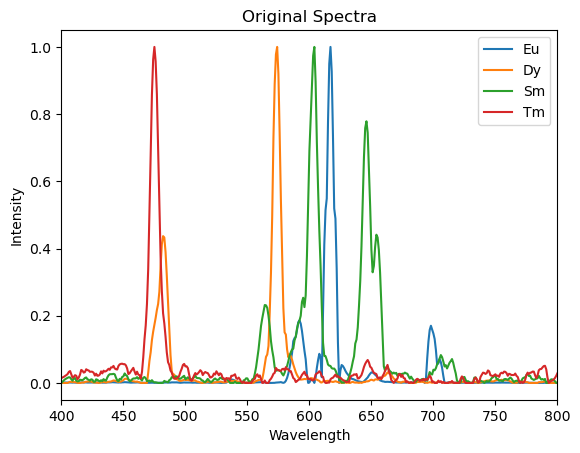

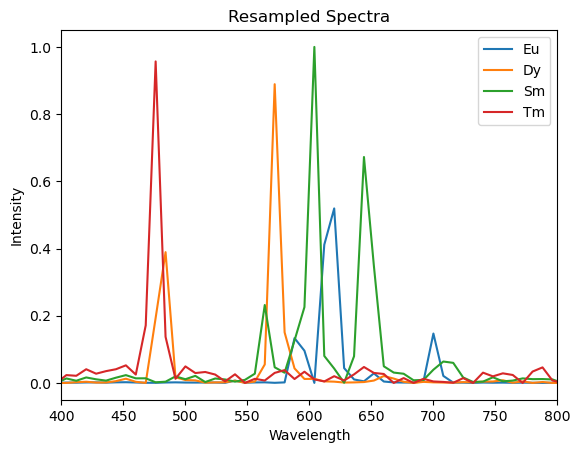

In [8]:
from scipy.signal import savgol_filter

# plot the ground truth spectra
# Specify the file path of the CSV file
file_path = "mrbles_spectra_20230412.csv"
# Read the CSV file into a NumPy array
data = np.genfromtxt(file_path, delimiter=',')
# Extract the wavelengths and spectra from the data
wavelengths_gt = data[1:, 0]
spectra_gt = data[1:, 2:7] - np.expand_dims(data[1:,1], axis = 1)
# remove the Dy duplicate
spectra_gt = np.delete(spectra_gt, 1, axis=1)
mrblesnew = np.zeros((spectra_gt.shape[1], len(wavelengths)))

# Remove the peak near 580
idx = np.where((wavelengths_gt >= 582) & (wavelengths_gt <= 592))[0]
peakstart = idx[0]
peakend = idx[-1]

for i in range(0, spectra_gt.shape[1]):
    spec = spectra_gt[:, i]
    spec[idx[0]:idx[-1]] = np.linspace(spec[idx[0]-1], spec[idx[-1]+1], idx[-1] - idx[0])  # remove the peak near 580
    spectra_gt[:, i] = spec
    #filter with savitzky golay
    spectra_gt[:, i] = savgol_filter(spectra_gt[:, i], window_length=11, polyorder=2)
    # normalize the spectra
    spectra_gt[:, i] = spectra_gt[:, i] / np.amax(spectra_gt[:, i])
    # remove negative values
    spectra_gt[:, i] = np.maximum(spectra_gt[:, i], 0)
    mrblesnew[i,:] = np.interp(wavelengths, wavelengths_gt, spectra_gt[:, i], left=0, right=0)
gt_idx = 0

plt.figure()
plt.plot(wavelengths_gt, spectra_gt)
labels =['Eu', 'Dy', 'Sm','Tm']
plt.legend(labels)
plt.xlabel('Wavelength')
plt.ylabel('Intensity')
plt.title('Original Spectra')
plt.xlim([400,800])
plt.figure()
for i in range(mrblesnew.shape[0]):
    plt.plot(wavelengths, mrblesnew[i, :])
plt.xlabel('Wavelength')
plt.ylabel('Intensity')
labels =['Eu', 'Dy', 'Sm','Tm']
plt.legend(labels)
plt.title('Resampled Spectra')
plt.xlim([400,800])
plt.show()
# resample at wavelengths


# Draw CAL

In [9]:
#initialize x 
#choose size for beads. 
import imgviz

def placeBead(src, bcenter, bdiam, spectra=None):
    #place bead at location
    #if its a flat 2d image, then just place bead and return image
    if len(src.shape)<= 2:
        xout = imgviz.draw.circle(src, bcenter, bdiam, fill=1)
        return xout
    #else if it's 3d image, then place bead with spectra
    if len(src.shape)>2:
        xoutfull = src #make a copy to be safe
        #get index of where bead should go
        xout = imgviz.draw.circle(src[:,:,0], bcenter, bdiam, fill=1)
        a = np.where(xout ==1)
        pmax = len(a[0])
        for p in range(pmax):
            yval = a[0][p]
            xval = a[1][p]
            xoutfull[yval,xval,:] = spec
        return xoutfull
    return src

def genBeadloc(src,numBeads,specnum=1,buffer=0):
    (dim0,dim1,dim2) = src.shape
    yloc = np.random.randint(0+buffer,dim0-buffer,numBeads)
    xloc = np.random.randint(0+buffer,dim1-buffer,numBeads)
    s = np.random.randint(0,specnum,numBeads)
    return (yloc,xloc,s)

#use draw.circle to get indices
#then change indices myself

(-0.5, 599.5, 599.5, -0.5)

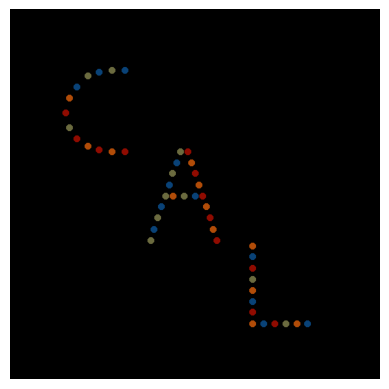

In [10]:
xsamples = dim1
ysamples = dim2
bead_loc = []

#The Letter C
bead_loc.append((int(.28*xsamples),int(.15*ysamples)))
bead_loc.append((int(.32*xsamples),int(.16*ysamples)))
bead_loc.append((int(.24*xsamples),int(.16*ysamples)))
bead_loc.append((int(.21*xsamples),int(.18*ysamples)))
bead_loc.append((int(.35*xsamples),int(.18*ysamples)))
bead_loc.append((int(.18*xsamples),int(.21*ysamples)))
bead_loc.append((int(.37*xsamples),int(.21*ysamples)))
bead_loc.append((int(.17*xsamples),int(.24*ysamples)))
bead_loc.append((int(.38*xsamples),int(.24*ysamples)))
bead_loc.append((int(.165*xsamples),int(.275*ysamples)))
bead_loc.append((int(.385*xsamples),int(.275*ysamples)))
bead_loc.append((int(.165*xsamples),int(.31*ysamples)))
bead_loc.append((int(.385*xsamples),int(.31*ysamples)))


# The Letter A
bead_loc.append((int(.505*xsamples),int(.47*ysamples)))
bead_loc.append((int(.505*xsamples),int(.44*ysamples)))
bead_loc.append((int(.505*xsamples),int(.5*ysamples)))
for ii in range(1,10):
    bead_loc.append((int((.355+ii*.03)*xsamples),int((.47+ii*.01)*ysamples)))
    bead_loc.append((int((.355+ii*.03)*xsamples),int((.47-ii*.01)*ysamples)))


# The Letter L
for ii in range(1,9):
    bead_loc.append((int((.61+ii*.03)*xsamples),int(.655*ysamples)))
for ii in range(1,7):
    bead_loc.append((int(.85*xsamples),int((.625+ii*.03)*ysamples)))

bdiam = 10
xinit = np.zeros_like(spectral_filter_ideal, dtype=float)
# reorder the dimensions to be compatible with the function
xinit = np.transpose(xinit, (1, 2, 0))
for k in range(len(bead_loc)):
    #spec = mrblesnew[torch.randint(5,(1,1)),:]
    spec = mrblesnew[np.mod(k,len(mrblesnew)),:] #cycle through
    xcal = placeBead(xinit, bead_loc[k],bdiam, spectra = spec)

plt.figure()
HSI_data = np.reshape(xcal, [-1,dim0])
false_color = sdc.HSI2RGB_jax(wavelengths, HSI_data ,dim2, dim1, 65, False)
plt.imshow(false_color**.8)
plt.axis('off')

### diffuser measurement

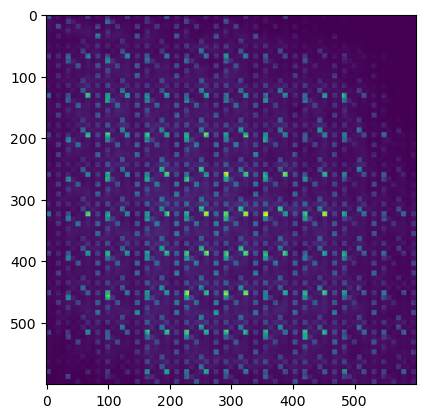

In [11]:
object = np.transpose(xcal, (2,0,1))

paddings = (
    (0, 0, 0),
    (np.ceil(object.shape[1] / 2).astype(int), np.floor(object.shape[1] / 2).astype(int), 0),
    (np.ceil(object.shape[2] / 2).astype(int), np.floor(object.shape[2] / 2).astype(int), 0),
)
padded_object = jax.lax.pad(object, 0.0, paddings)
fft_object = jnp.fft.fft2(padded_object)
fft_product = hfftpad * fft_object

ifft_product = jnp.fft.ifftshift(jnp.fft.ifft2(fft_product), axes=(1, 2))
ifft_product = abs(sdc.jax_crop2D(object.shape, ifft_product))
ifft_product = ifft_product * spectral_filter
plt.imshow(np.sum(ifft_product,axis=0))

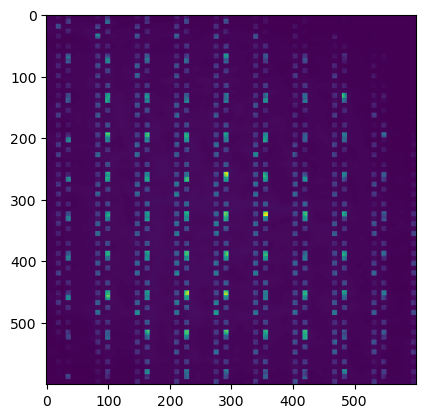

In [12]:
plt.imshow(np.sum(ifft_product[20:30,:,:],axis=0))

In [13]:
# simulate regular diffusercam forwrd model. 
# Load and crop PSF

x = np.transpose(xcal, (2, 0, 1))
# move calibration to jax
psf_diffuser = psf
y_diffuser = sdc.jax_forward_model(x,spectral_filter, hfftpad)

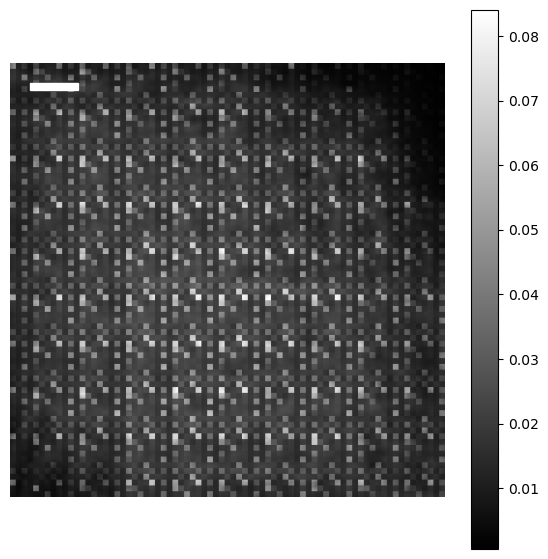

In [14]:
fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(y_diffuser**.5, cmap='gray')
# plt.colorbar()  
# plt.clim([0,.02])
plt.axis('off')
scalebar = drawscalebar(ax, superpixel_size,spectral_camera_pixel_size, scalebarname = '')
ax.add_artist(scalebar)
plt.colorbar()

### original measurement

In [15]:
# simulate with delta psf. 
psf_delta = np.zeros_like(psf)
psf_delta[psf_delta.shape[0]//2,psf_delta.shape[1]//2] = 1
hpad = jax.lax.pad(psf_delta[None, ...], 0.0, padding).squeeze()
hfftpad = jnp.fft.fft2(hpad)
y_delta = sdc.jax_forward_model(x, spectral_filter, hfftpad)

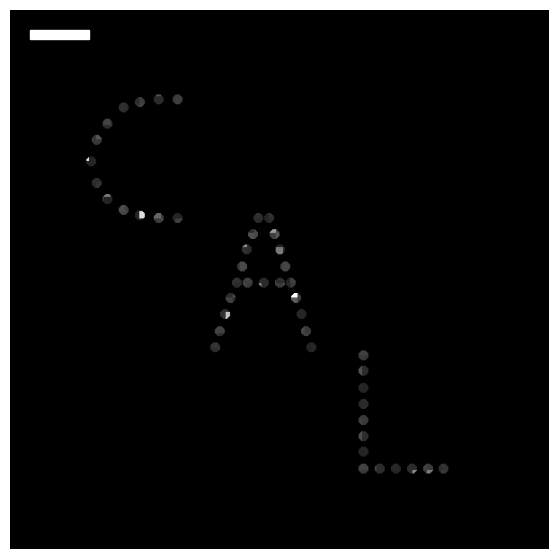

In [16]:
fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(y_delta**.5, cmap='gray')
# plt.colorbar()  
# plt.clim([0,.5])
plt.axis('off')
scalebar = drawscalebar(ax, superpixel_size,spectral_camera_pixel_size, scalebarname = '')
ax.add_artist(scalebar)

### magnified measurement

In [17]:
from jax.image import resize
# Define the scale factor and new shape
scale_factor = 8
zoom_size = (int(x.shape[1]/scale_factor), int(x.shape[2]/scale_factor))
# crop the original image
xzoom = sdc.jax_crop2D(zoom_size,x)

# Scale the array using bilinear interpolation
xmag = resize(np.asarray(xzoom), x.shape, method='linear')
y_mag = sdc.jax_forward_model(xmag, spectral_filter, hfftpad)

(-0.5, 599.5, 599.5, -0.5)

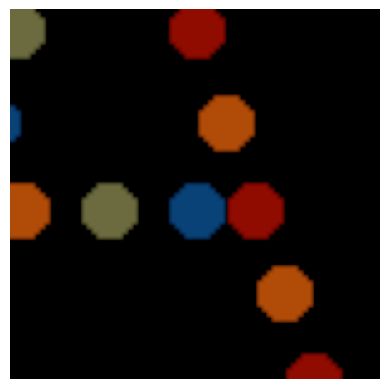

In [18]:
plt.figure()
HSI_data = np.reshape(np.transpose(xmag, (1,2,0)), [-1,dim0])
false_color = sdc.HSI2RGB_jax(wavelengths, HSI_data ,dim2, dim1, 65, False)
plt.imshow(false_color**.8)
plt.axis('off')

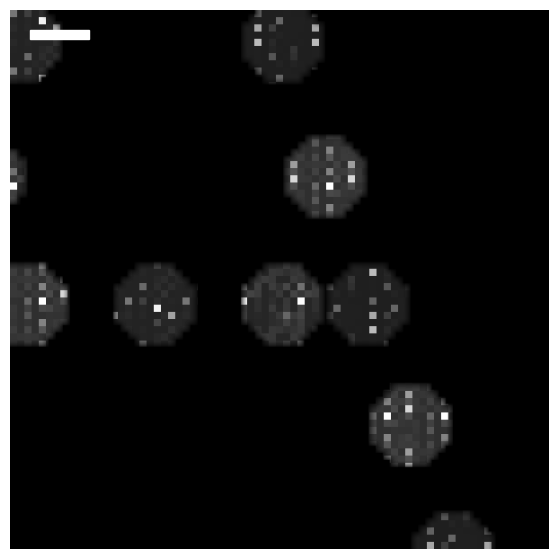

In [19]:
fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(y_mag**.5, cmap='gray')
# plt.colorbar()  
plt.clim([0,1])
plt.axis('off')
scalebar = drawscalebar(ax, superpixel_size,spectral_camera_pixel_size, scalebarname = '')
ax.add_artist(scalebar)

## defocused measurement

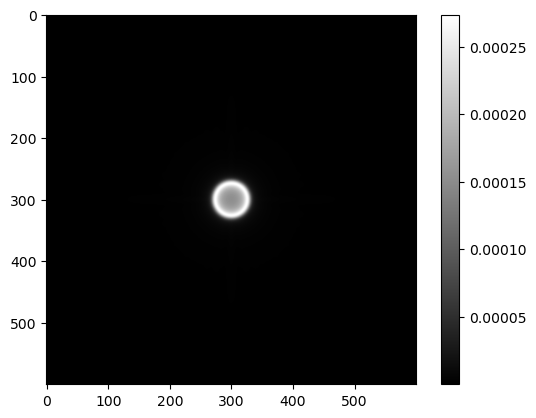

In [20]:
# use simulation to get defocused psf. 

# create quadratic phase...
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameters
size = [psf.shape[0],psf.shape[1]] # Grid size
source = np.array([0,0, 0])  # Source location (y,x,z) in micron
wavelength = 500e-3 # Wavelength # 500 nm in um
pixsize =  wavelength/20 # Pixel size in micron
amplitude = 1  # Wave amplitude

# Create a 2D grid
x1 = np.linspace(-size[1]*pixsize/2, size[1]*pixsize/2, size[1])
y1 = np.linspace(-size[0]*pixsize/2, size[0]*pixsize/2, size[0])
z1 = 2  # microns above source
X, Y= np.meshgrid(x1, y1)

# Calculate the distance from the source
R = np.sqrt((X - source[1])**2 + (Y - source[0])**2 + (z1 - source[2])**2)

# Calculate the phase
phase = 2*np.pi/wavelength * R
amp = amplitude/R
# circle aperture
aperture = np.zeros_like(X)
r = np.sqrt((X)**2 + (Y)**2)
aperture[r<np.amax(X)] = 1

uxy = amp*np.exp(1j * phase)*aperture

fuxy = np.fft.fftshift(np.fft.fft2(uxy))

from scipy.ndimage import gaussian_filter
psf_defocus = np.abs(gaussian_filter(np.abs(fuxy), sigma=3))
psf_defocus = psf_defocus/np.sum(psf_defocus)

plt.figure()
plt.imshow(psf_defocus, cmap = 'gray')
plt.colorbar()


/tmp/ipykernel_3243705/1575900754.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  defocused_bmp = np.array(imageio.imread('Figures/calbeadsim/christian_defocused.bmp'))
/tmp/ipykernel_3243705/1575900754.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  focused_bmp = np.array(imageio.imread('Figures/calbeadsim/christian_focused.bmp'))


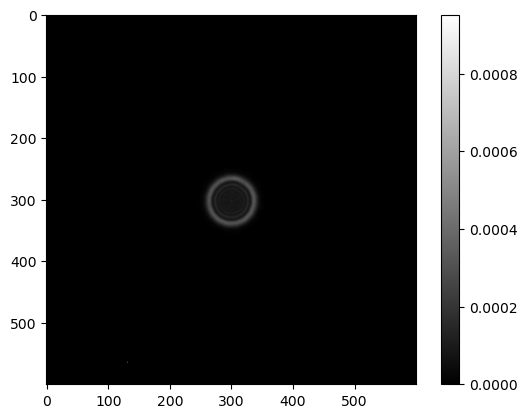

In [21]:
# use measurement instead. 
# read numpy array from image
import imageio

# Load the BMP image
defocused_bmp = np.array(imageio.imread('Figures/calbeadsim/christian_defocused.bmp'))
focused_bmp = np.array(imageio.imread('Figures/calbeadsim/christian_focused.bmp'))

cen = np.argmax(focused_bmp)
cen = np.unravel_index(cen, focused_bmp.shape)

#crop arround defocused image

psf_defocus = defocused_bmp[cen[0]-int(psf_diffuser.shape[0]/2):cen[0]+int(psf_diffuser.shape[0]/2),cen[1]-int(psf_diffuser.shape[1]/2):cen[1]+int(psf_diffuser.shape[1]/2)]
# Convert the image to a numpy array
#subtract background
psf_defocus = psf_defocus - np.amin(psf_defocus)
psf_defocus = psf_defocus/np.sum(psf_defocus)
plt.imshow(psf_defocus, cmap = 'gray')
plt.colorbar()

In [22]:
hpad = jax.lax.pad(psf_defocus[None, ...], 0.0, padding).squeeze()
hfftpad = jnp.fft.fft2(hpad)
y_defocus = sdc.jax_forward_model(x, spectral_filter, hfftpad)

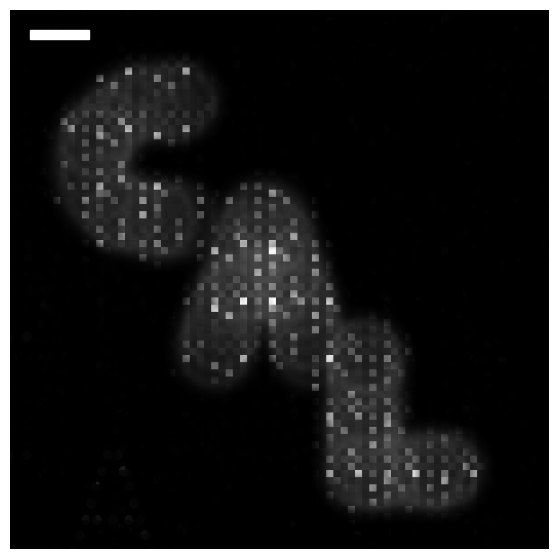

In [23]:
fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(y_defocus**.5, cmap='gray')
# plt.colorbar()
# plt.clim([0,.07])
plt.axis('off')
scalebar = drawscalebar(ax, superpixel_size,spectral_camera_pixel_size, scalebarname = '')
ax.add_artist(scalebar)

### blurred measurement


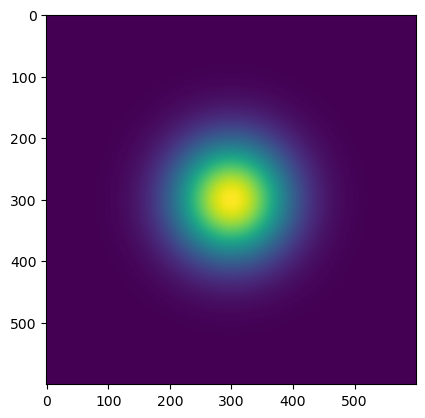

In [24]:
import numpy as np
from scipy.ndimage import gaussian_filter

# Create a PSF with a Gaussian blur
psf_blur = np.zeros_like(psf)
psf_blur[int(psf_blur.shape[0] / 2), int(psf_blur.shape[1]/2)] = 1.0  # Set the center pixel to 1.0
psf_blur = gaussian_filter(psf_blur, sigma=66.0)  # Apply Gaussian blur with sigma=1.0

# Normalize the PSF
psf_blur /= np.sum(psf_blur)

plt.imshow(psf_blur)

In [25]:
# simulate with blur psf. 

hpad = jax.lax.pad(psf_blur[None, ...], 0.0, padding).squeeze()
hfftpad = jnp.fft.fft2(hpad)
y_blur = sdc.jax_forward_model(x, spectral_filter, hfftpad)

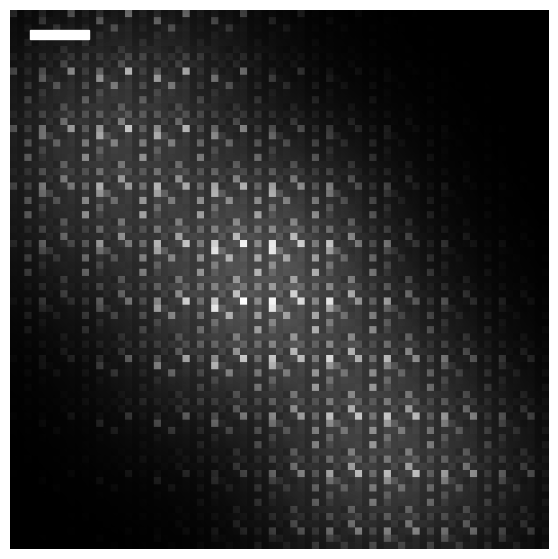

In [26]:
fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(y_blur**.5, cmap='gray')
# plt.colorbar()  
# plt.clim([0,.03])
plt.axis('off')
scalebar = drawscalebar(ax, superpixel_size,spectral_camera_pixel_size, scalebarname = '')
ax.add_artist(scalebar)

## Save the measurements and create configs

## optional: add noise to the measurements

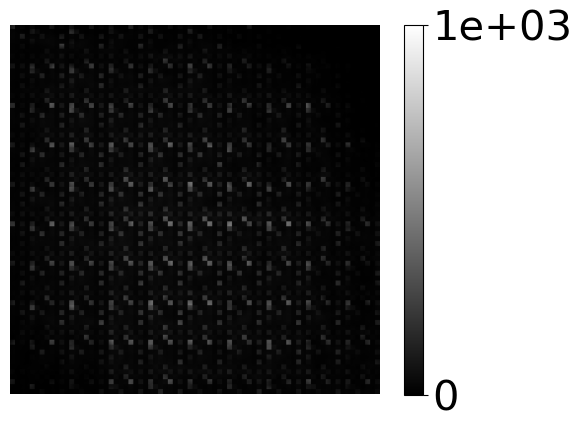

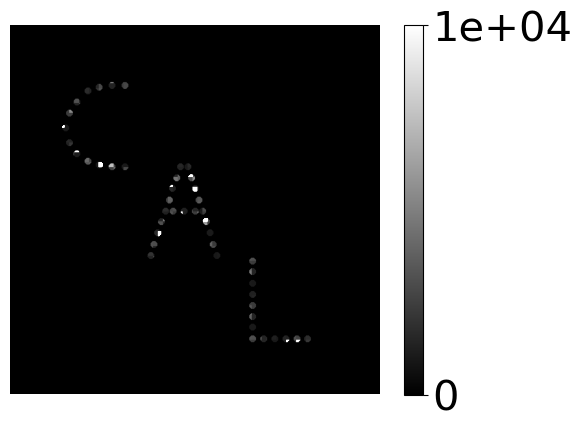

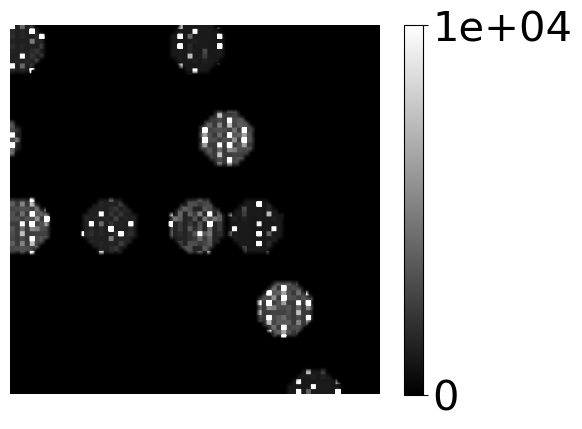

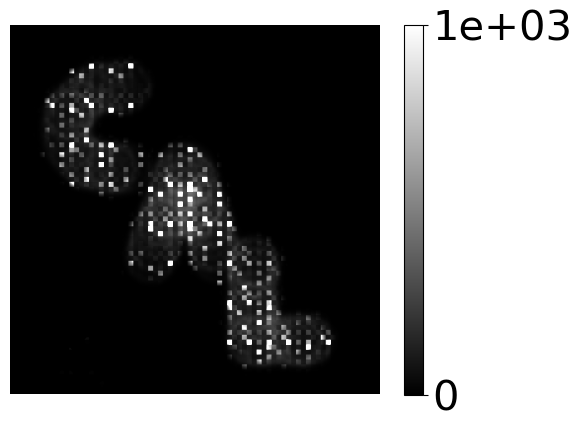

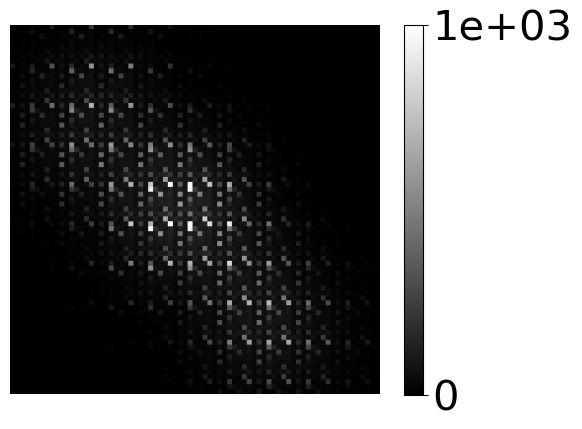

In [64]:
# stack all the measurements and psfs
# meas_stack = [y_diffuser, y_delta, y_mag, y_defocus, y_blur]

# plot diffuser and blur together
for k in range(len(meas_stack)):
    # clip negative values to zero. 
    plt.figure()
    plt.imshow(meas_stack[k]*scale_factor_to_int, cmap = 'gray')
    # turn off axis
    plt.axis('off')
    cbar = plt.colorbar()
    if k in [0,3,4]:
        plt.clim(0, 1e3)
        cbar.set_ticks([0, 1e3])
    else:
        plt.clim(0, 1e4)
        cbar.set_ticks([0, 1e4])
    # set tick to be min and max
    cbar.set_ticklabels(['0' if tick == 0 else f'{tick:.0e}' for tick in cbar.get_ticks()], fontsize=30)


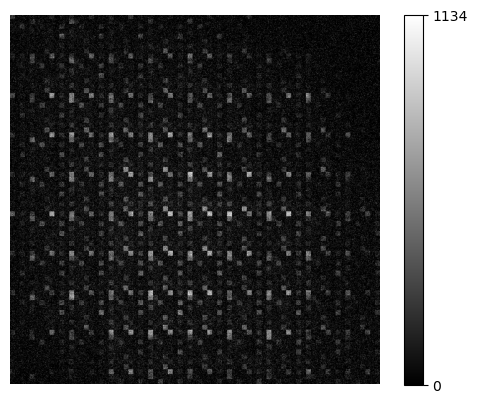

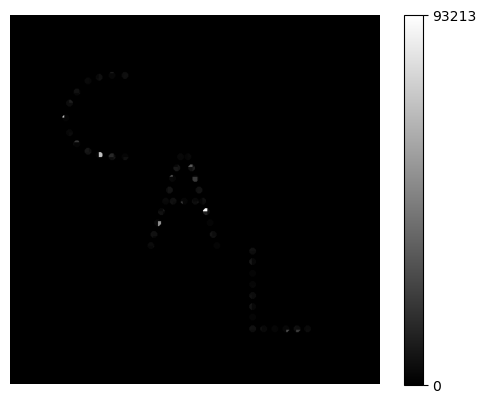

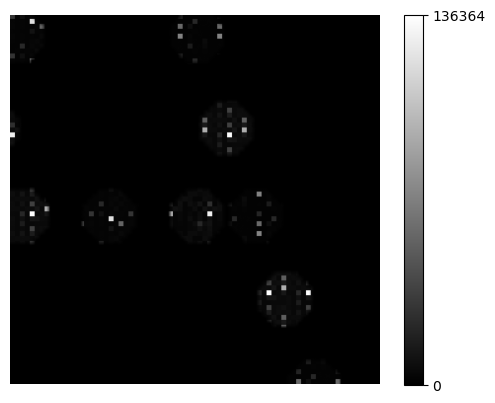

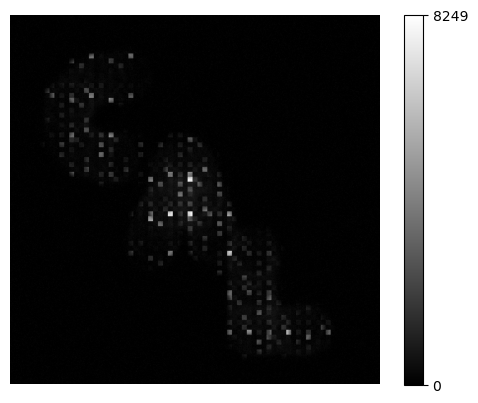

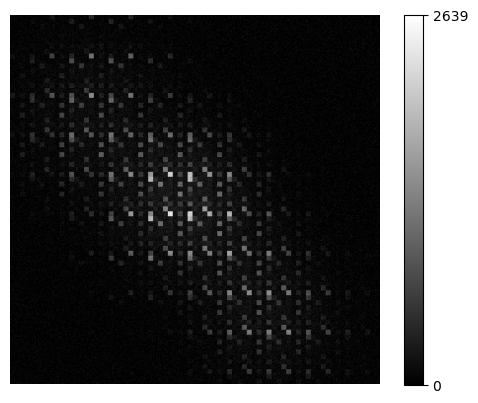

In [59]:
# stack all the measurements and psfs
meas_stack = [y_diffuser, y_delta, y_mag, y_defocus, y_blur]
psf_stack = [psf_diffuser, psf_delta, psf_delta, psf_defocus, psf_blur]
scale_factor_to_int = 2**16
noisy_meas_stack = [np.zeros_like(meas) for meas in meas_stack]
poisson_lambda_scale = 1
gaussian_noise_std = 100 # add some noise to the background dark pixels
power = 1
for k in range(len(meas_stack)):
    meas = meas_stack[k]
    meas_int = (meas*scale_factor_to_int).astype(np.int32)
    poisson_noise = np.random.poisson(meas_int/poisson_lambda_scale)
    gauss_noise = np.random.normal(0,gaussian_noise_std, size = meas.shape)
    noisy_meas = (poisson_noise+meas_int+gauss_noise)
    # clip negative values to zero. 
    noisy_meas = jnp.where(noisy_meas < 0, 0, noisy_meas)
    noisy_meas_stack[k] = noisy_meas
    plt.figure()
    plt.imshow(noisy_meas_stack[k]**power, cmap = 'gray')
    # turn off axis
    plt.axis('off')
    cbar = plt.colorbar()
    # set tick to be min and max
    cbar.set_ticks([np.amin(noisy_meas_stack[k])**power, np.amax(noisy_meas_stack[k]**power)])
    # cbar.set_ticklabels([f'{tick * .0f}' for tick in cbar.get_ticks()], fontsize=30)


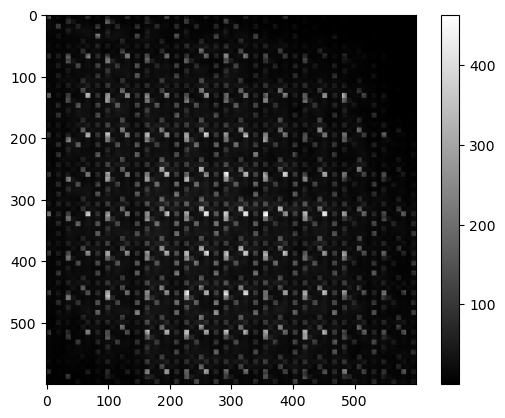

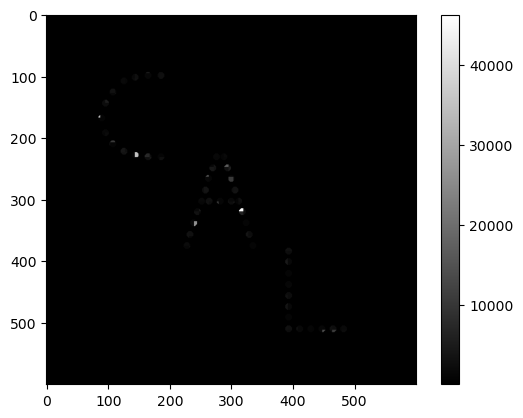

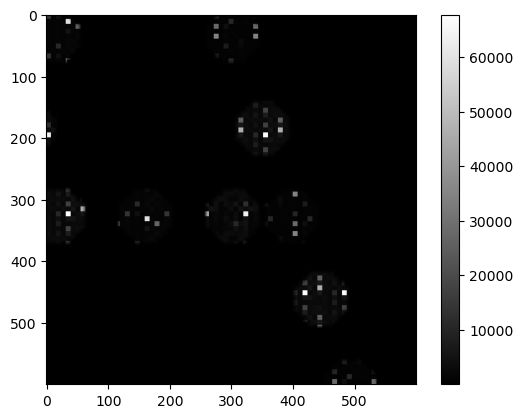

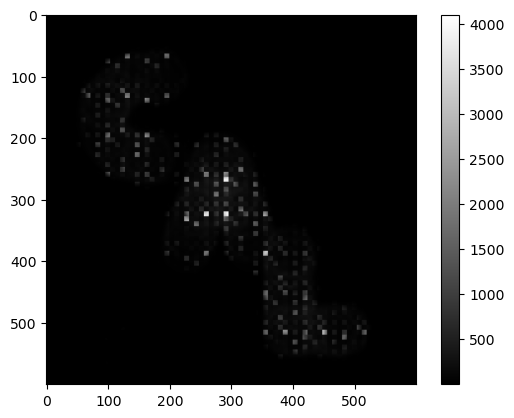

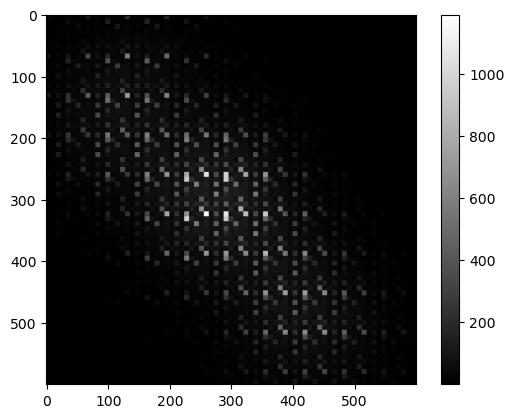

In [29]:
# save the measurements and psfs in a folder
import tifffile

# Create the folder if it doesn't exist
folder_names = ['diffuser', 'delta', 'mag', 'defocus', 'blur']

[N1,N2,N3] = normalized_filter_cube.shape
padding = ((crop_indices[0],N2-crop_indices[1],0),(crop_indices[2],N3-crop_indices[3],0))
bits = 16  

HSI_data = np.reshape(xcal, [-1,dim0])
false_color = sdc.HSI2RGB_jax(wavelengths, HSI_data ,dim2, dim1, 65, False)

for k in range(len(meas_stack)):
    pathname = os.path.join(measurement_folder, folder_names[k])
    # create folder if it doesn't exist
    if not os.path.exists(pathname):
        os.makedirs(pathname)
    # pad the measurement so it matches the size of the spectral filter array
    padded_meas = jax.lax.pad(meas_stack[k]*(2**bits), 0.0, padding).squeeze()
    plt.figure()
    plt.imshow(padded_meas, cmap='gray')
    plt.colorbar()
    # save the meas as a tiff file
    tifffile.imwrite(os.path.join(pathname, 'meas.tiff'), (padded_meas).astype(np.uint16))
    # save the psf as npy file
    np.save(os.path.join(pathname, 'psf.npy'), psf_stack[k])
    # save the object file as gt.tiff
    tifffile.imwrite(os.path.join(pathname, 'gt.tiff'), (false_color*(2**bits)).astype(np.uint16))   

# create the config files if it doesn't exist 
config_folder = 'sim_configs'
if not os.path.exists(config_folder):
    os.makedirs(config_folder)

## Try ideal demosaicing for delta psfs

#### create helper demosaicing function and use

In [30]:
from scipy.interpolate import griddata
from scipy.interpolate import RBFInterpolator

def demosaicing(spectral_filter, m, interp_method = 'rbf', plot_flag = True, epsilon =1):
    dim0, dim1, dim2  = spectral_filter.shape
    maxes = np.argmax(spectral_filter, axis = 0)
    if plot_flag:
        plt.figure()
        plt.imshow(maxes, cmap = cmap_rainbow)
        plt.colorbar()

    m = m/scale_factor_to_int # undo integer pixels (optional)
    if plot_flag:
        plt.figure()
        plt.imshow(m)
        plt.colorbar()
    
    #2. separate out measurement pixels into different channels based on max wavelength transmittance channel. 
    m3D = np.zeros((dim0, m.shape[0], m.shape[1]))
    y_indices, x_indices = np.indices(m.shape)
    m3D[maxes, y_indices, x_indices] = m


    #3.  normalize by the max transmission of each spectral channel. 
    max_trans = jnp.max(spectral_filter, axis = 0)
    m3D = m3D/max_trans[None, ...]
    if plot_flag:
        plt.figure()
        plt.imshow(m3D[10], cmap = 'gray')
        plt.colorbar()

    
    yrange = np.arange(dim1)
    xrange = np.arange(dim2)
    # 4. Create a meshgrid for interpolation
    grid_y, grid_x = np.meshgrid(yrange, xrange)

    xk_demosaic = np.zeros_like(m3D)

    # 5. Iterate through each wavelength channel and interpolate
    for w in range(dim0):
        slice_2d = m3D[w]

        # Get nonzero indices
        if w< dim0-1:
            thresh = 0.1
        else:
            thresh = 0.01
        nonzero_mask = spectral_filter[w] > thresh # get the pixels for this filter
        y_nonzero, x_nonzero = np.where(nonzero_mask)

        slice_val = slice_2d[y_nonzero, x_nonzero]

        if interp_method == 'rbf':
            points = np.column_stack((x_nonzero, y_nonzero))
            rbf_interpolator = RBFInterpolator(points, slice_val, neighbors = 4, kernel = 'gaussian', epsilon=epsilon)
            interpolated_val = rbf_interpolator(np.column_stack((grid_x.ravel(), grid_y.ravel()))).reshape(grid_x.shape).T
        else:
        # interpolate and store
        
            interpolated_val = griddata((x_nonzero, y_nonzero), slice_val, (grid_x, grid_y), method=interp_method, fill_value=m_offset).T
        # 
        # clip neg values 
        interpolated_val[interpolated_val<0] = 0

        xk_demosaic[w] = interpolated_val
    
        if plot_flag and w ==int(dim0/2):
            plt.figure()
            plt.subplot(1,2,1)
            plt.imshow(slice_2d)
            plt.subplot(1,2,2)
            plt.imshow(interpolated_val)

    return xk_demosaic, m3D

(-0.5, 599.5, 599.5, -0.5)

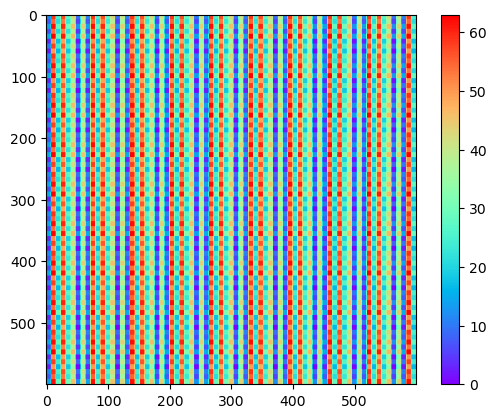

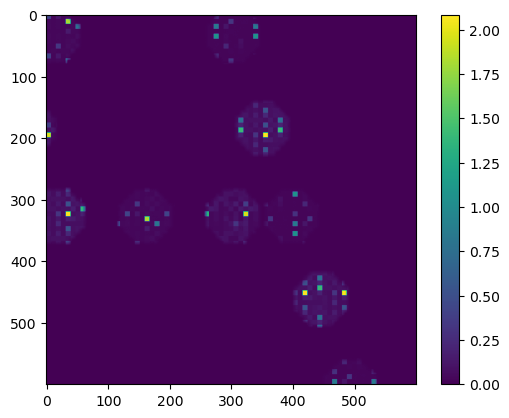

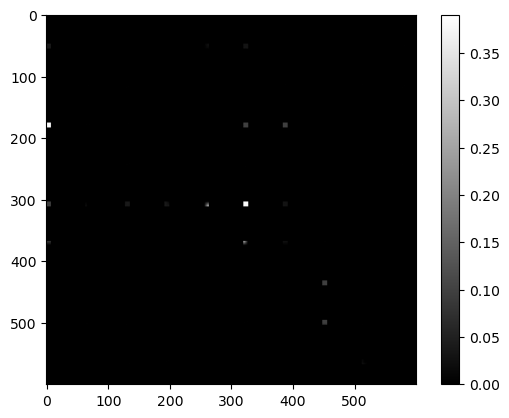

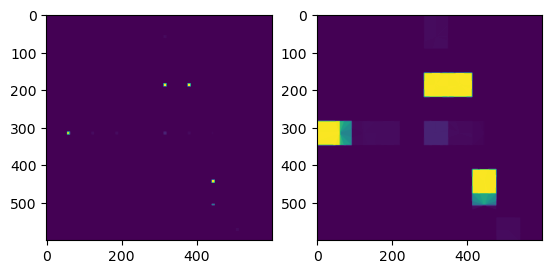

<Figure size 640x480 with 0 Axes>

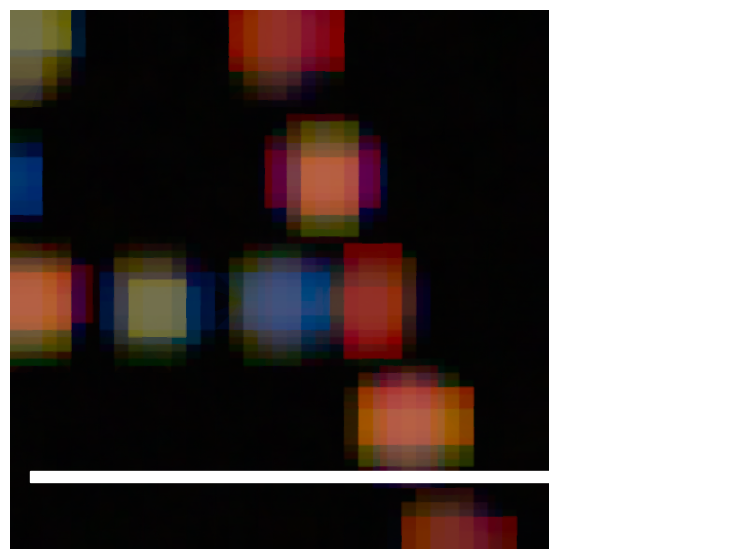

In [31]:

m = noisy_meas_stack[2]

from jax import device_put
# Move data to GPU
spectral_filter_gpu = device_put(spectral_filter)
m_gpu = device_put(m)

# Perform demosaicing on GPU
(xk_mag, m3D) = demosaicing(spectral_filter_gpu, m_gpu, interp_method='rbf')

gamma = 0.8
plt.figure()
HSI_data = np.reshape(np.transpose(xk_mag, (1,2,0)), [-1,dim0])
false_color = sdc.HSI2RGB_jax(wavelengths, HSI_data ,dim2, dim1, 65, False)
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(false_color**gamma)
scalebarum = drawscalebar(ax, 100, recon_pixel_size, mag = 8*mag_size, scalebarname='', loc = 'lower left', size_vertical=12 )
ax.add_artist(scalebarum)
ax.axis('off')
plt.axis('off')


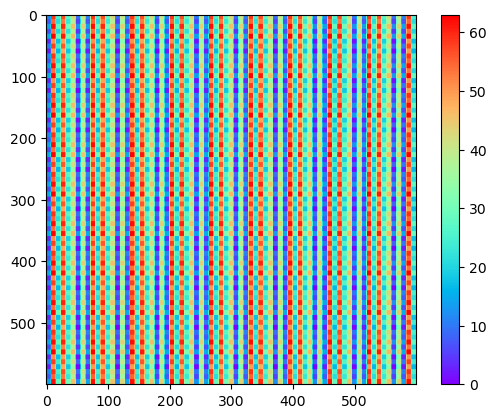

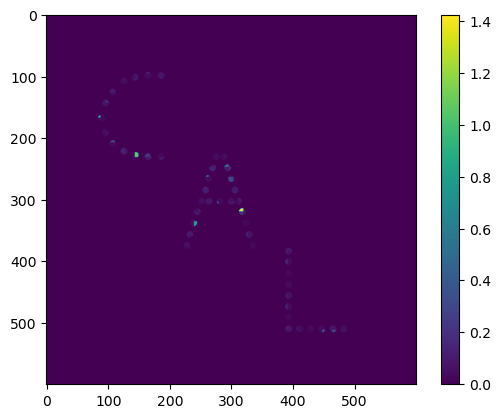

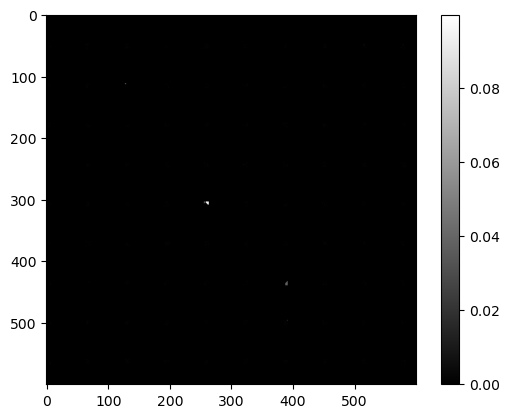

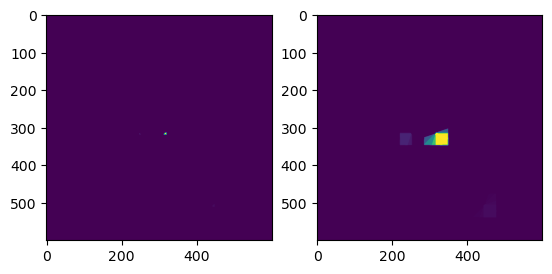

<Figure size 640x480 with 0 Axes>

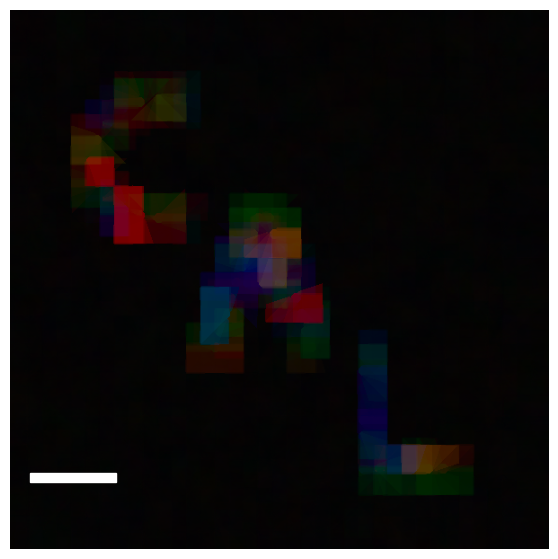

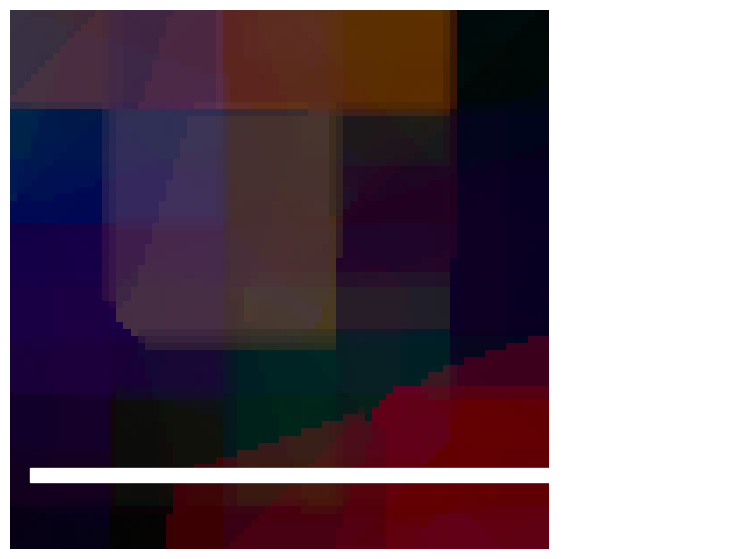

In [32]:
m = noisy_meas_stack[1]
(xk_orig, m3D) = demosaicing(spectral_filter, m, interp_method='rbf')

gamma = 0.8

plt.figure()
HSI_data = np.reshape(np.transpose(xk_orig, (1,2,0)), [-1,dim0])
false_color = sdc.HSI2RGB_jax(wavelengths, HSI_data ,dim2, dim1, 65, False)
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(false_color**gamma)
scalebarum = drawscalebar(ax, 100, recon_pixel_size, mag = mag_size, scalebarname='', loc = 'lower left')
ax.add_artist(scalebarum)
ax.axis('off')
plt.axis('off')

fig, ax = plt.subplots(figsize=(7, 7))
center_x, center_y = false_color.shape[1] // 2, false_color.shape[0] // 2
zoom_width=38
ax.imshow(false_color[center_x-zoom_width:center_x+zoom_width, center_y-zoom_width:center_y+zoom_width]**gamma)
ax.axis('off')
# add a scalebar
scalebar = drawscalebar(ax, 100, recon_pixel_size, mag = mag_size, scalebarname='', loc = 'lower left', size_vertical = 2)
ax.add_artist(scalebar)
    # plt.show()

In [ ]:
# save the demosaiced results
folder_name = 'delta'
pathname = os.path.join(os.path.join(measurement_folder, folder_name), 'delta_demosaiced')
np.save(xk_orig, pathname)

folder_name = 'mag'
pathname = os.path.join(os.path.join(measurement_folder, folder_name), 'mag_demosaiced')
np.save(xk_mag, pathname)

#### optional: try plotting delta psf by just dividing by spectral filter

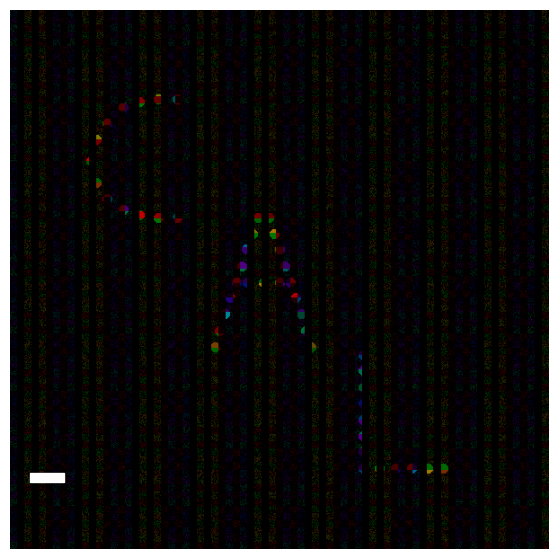

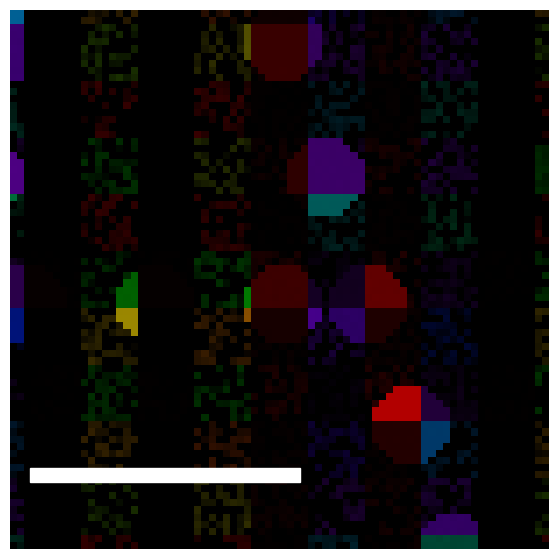

In [32]:
gamma = 0.3
HSI_data = np.reshape(np.transpose(m3D, (1,2,0)), [-1,dim0])
false_color = sdc.HSI2RGB_jax(wavelengths, HSI_data ,dim2, dim1, 65, False)
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(false_color**gamma)
scalebarum = drawscalebar(ax, 100, recon_pixel_size, mag = mag_size, scalebarname='', loc = 'lower left')
ax.add_artist(scalebarum)
ax.axis('off')
plt.axis('off')

fig, ax = plt.subplots(figsize=(7, 7))
center_x, center_y = false_color.shape[1] // 2, false_color.shape[0] // 2
zoom_width=38
ax.imshow(false_color[center_x-zoom_width:center_x+zoom_width, center_y-zoom_width:center_y+zoom_width]**gamma)
ax.axis('off')
# add a scalebar
scalebar = drawscalebar(ax, 100, recon_pixel_size, mag = mag_size, scalebarname='', loc = 'lower left', size_vertical = 2)
ax.add_artist(scalebar)
    # plt.show()

### optional: Try the downsampling

In [100]:

def downsample(spectral_filter, m, stride = 64, plot_flag = True):
    dim0, dim1, dim2  = spectral_filter.shape
    maxes = np.argmax(spectral_filter, axis = 0)
    if plot_flag:
        plt.figure()
        plt.imshow(maxes, cmap = cmap_rainbow)
        plt.colorbar()

    # m = m/scale_factor_to_int # undo integer pixels (optional)
    if plot_flag:
        plt.figure()
        plt.imshow(m)
        plt.colorbar()

    #2. separate out measurement pixels into different channels based on max wavelength transmittance channel. 
    m3D = np.zeros((dim0, m.shape[0], m.shape[1]))
    y_indices, x_indices = np.indices(m.shape)
    m3D[maxes, y_indices, x_indices] = m

    #3.  normalize by the max transmission of each spectral channel. 
    max_trans = np.max(spectral_filter, axis = 0)
    m3D = m3D/max_trans[None, ...]
    if plot_flag:
        plt.figure()
        plt.imshow(m3D[10], cmap = 'gray')
        plt.colorbar()

    #4.  downsample according tothe stride
    new_shape = (m3D.shape[0], m3D.shape[1] // stride, m3D.shape[2] // stride)

    # Initialize the downsampled array
    downsampled_m3D = np.zeros(new_shape)
    for i in range(new_shape[1]):
        for j in range(new_shape[2]):
            downsampled_m3D[:, i, j] = np.amax(m3D[:, i*stride:(i+1)*stride, j*stride:(j+1)*stride], axis=(1, 2))

    return downsampled_m3D
    

(-0.5, 1.5, 1.5, -0.5)

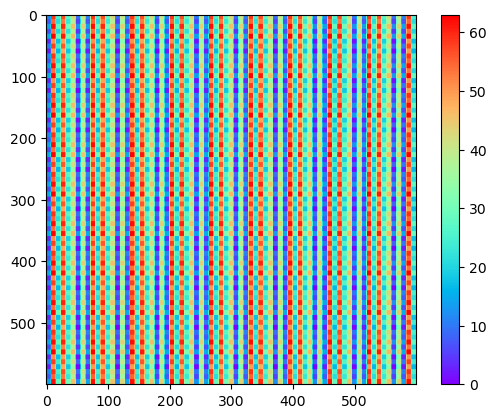

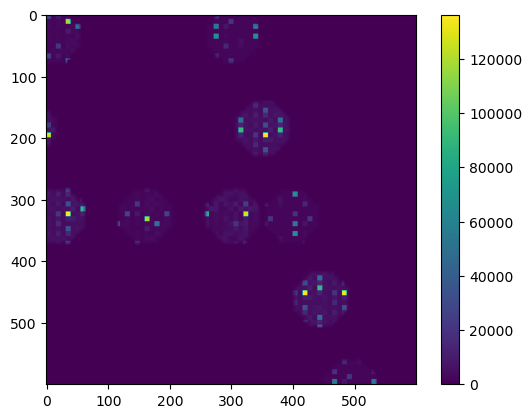

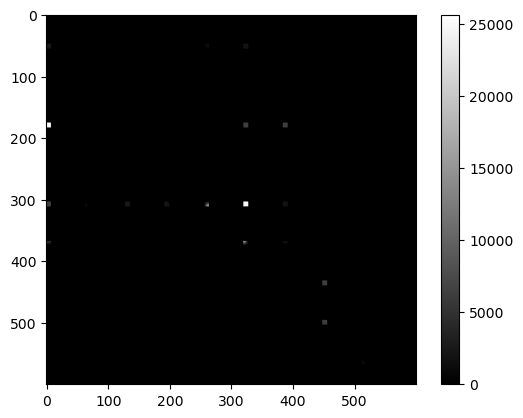

<Figure size 640x480 with 0 Axes>

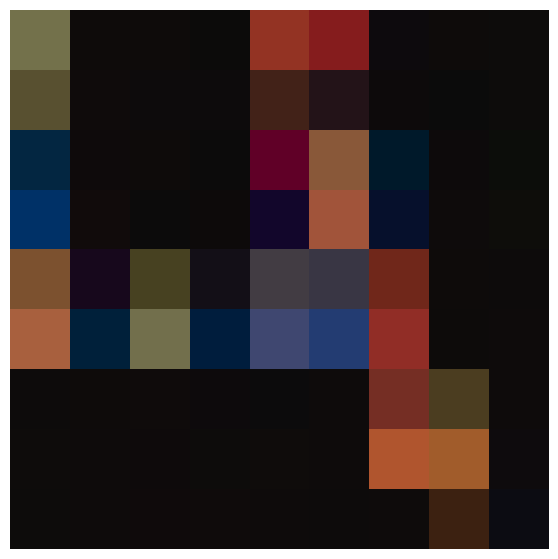

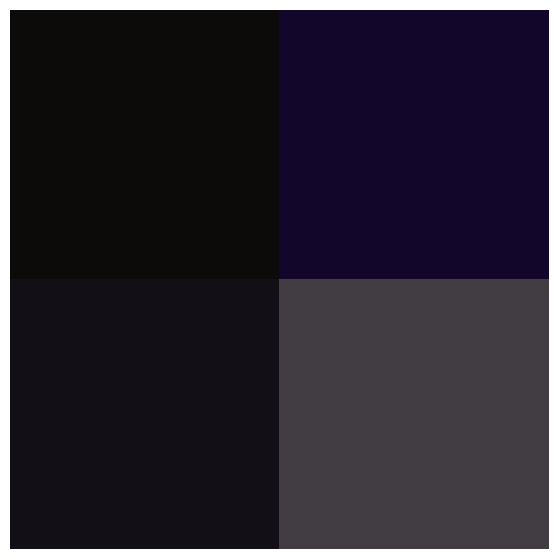

In [101]:

m = noisy_meas_stack[2]
# upsample 
stride =64
xk_orig_ds = downsample(spectral_filter, m, stride)

gamma =0.8
plt.figure()
HSI_data = np.reshape(np.transpose(xk_orig_ds, (1,2,0)), [-1,dim0])
false_color = sdc.HSI2RGB_jax(wavelengths, HSI_data ,xk_orig_ds.shape[2], xk_orig_ds.shape[1], 65, False)
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(false_color**gamma)
# scalebarum = drawscalebar(ax, 100, recon_pixel_size, mag = mag_size, scalebarname='', loc = 'lower left')
# ax.add_artist(scalebarum)
ax.axis('off')

fig, ax = plt.subplots(figsize=(7, 7))
center_x, center_y = false_color.shape[1] // 2, false_color.shape[0] // 2
zoom_width=int(np.ceil(38/stride))
ax.imshow(false_color[center_x-zoom_width:center_x+zoom_width, center_y-zoom_width:center_y+zoom_width]**gamma)
ax.axis('off')
# add a scalebar
# scalebar = drawscalebar(ax, 100, recon_pixel_size, mag = mag_size, scalebarname='', loc = 'lower left', size_vertical = 2)
# ax.add_artist(scalebar)
    # plt.show()

## Plot the reconstructions from config file runs

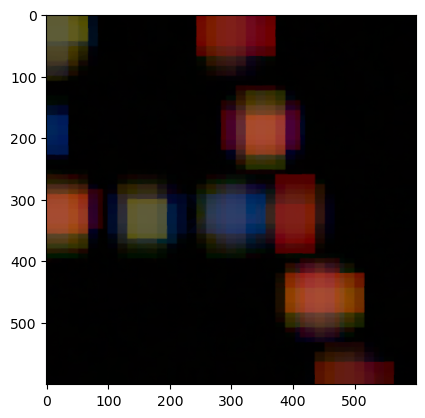

In [31]:
HSI_data = np.reshape(np.transpose(xk_orig, (1,2,0)), [-1,dim0])
false_color = sdc.HSI2RGB_jax(wavelengths, HSI_data ,dim2, dim1, 65, False)
plt.imshow(false_color)

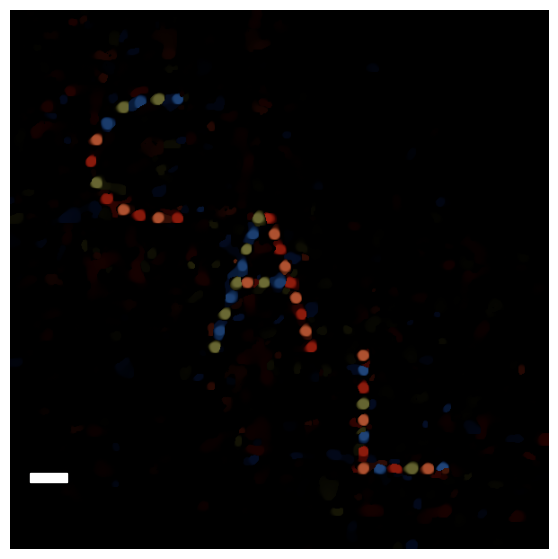

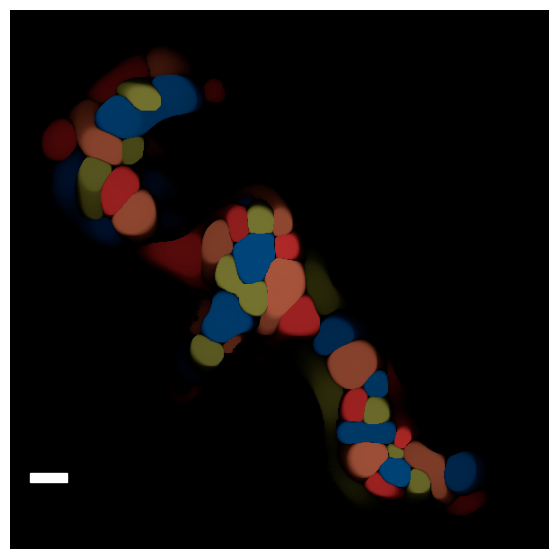

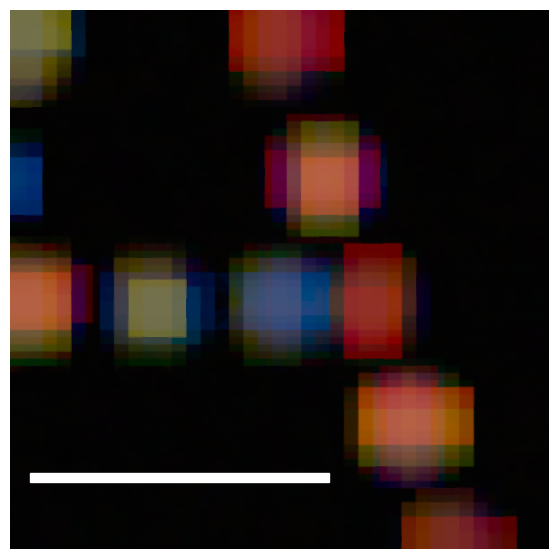

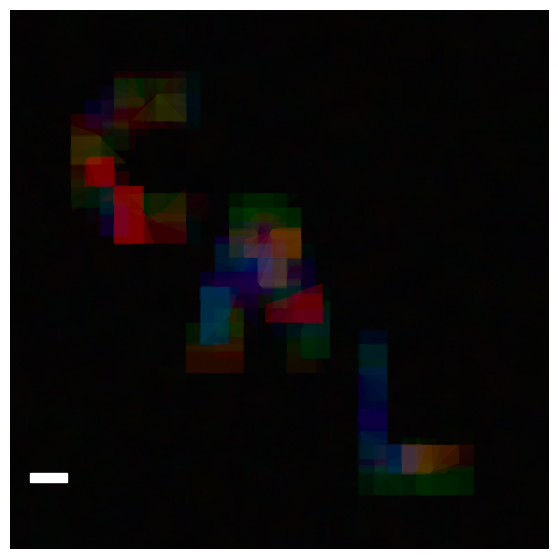

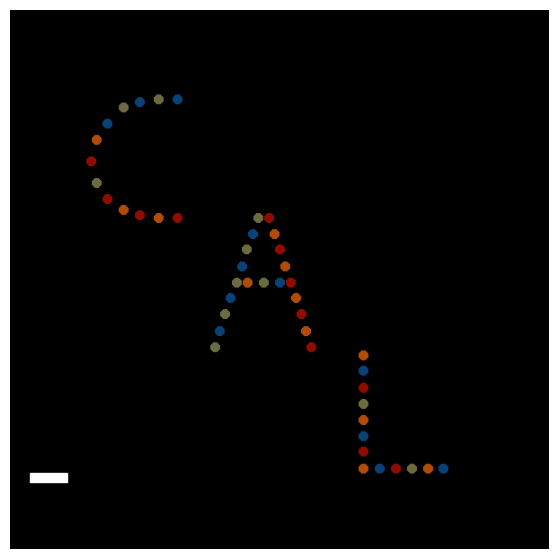

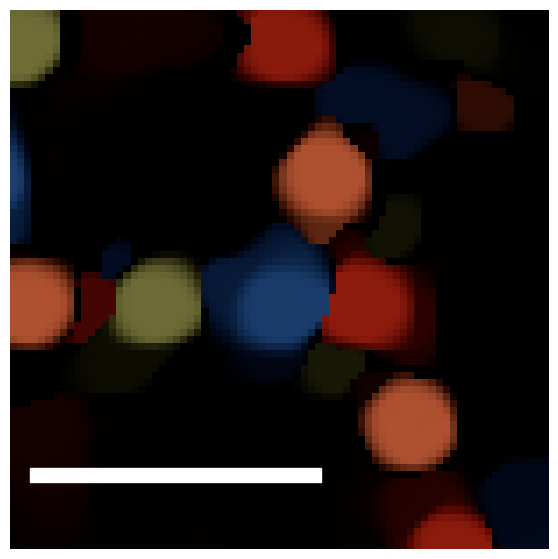

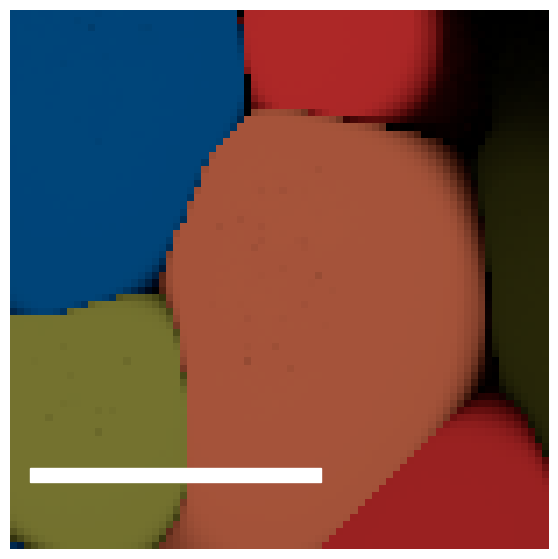

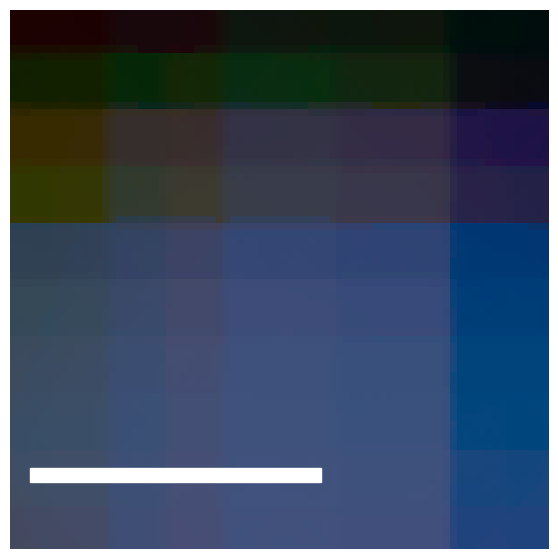

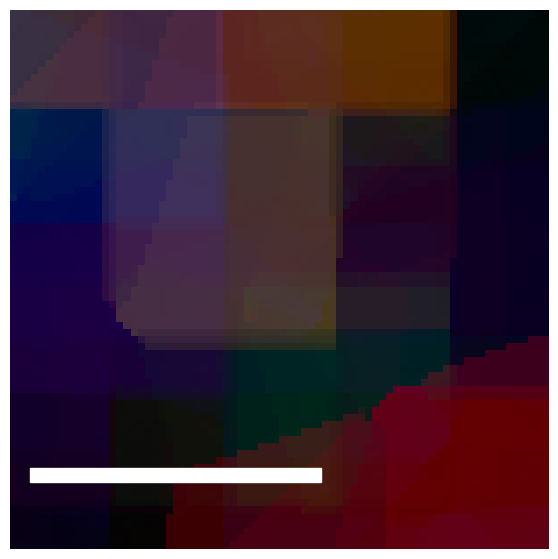

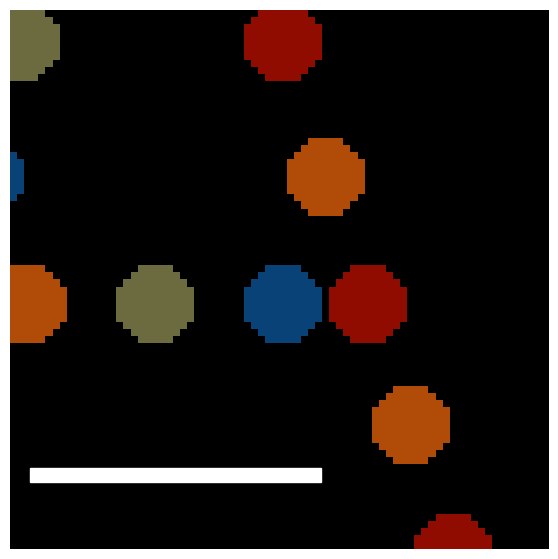

In [35]:
# run_ids = ['diffuser_7ddxx58w.pkl', 'delta_7u6u9q0u.pkl', 'mag_32an3oqa.pkl', 'blur_v80922nt.pkl']
run_ids = ['diffuser_a9he19ye.pkl', 'blur_50znn065.pkl']

datafolder = 'sim_data_ideal_offset'
false_color_stack = []
xk_stack = []
for run_id in run_ids:
    # extract the folder name from the run id
    folder_name = run_id.split('_')[0]
    # load the reconstruction
    recon_dict = np.load(os.path.join(datafolder, folder_name, run_id), allow_pickle=True)
    xk = recon_dict['xk']
    xk_stack.append(xk)

# add other data
datafolder = 'sim_data_ideal_offset'
xk_mag = np.load(os.path.join(datafolder, 'mag/mag_demosaiced.npy'))
xk_orig = np.load(os.path.join(datafolder, 'delta/delta_demosaiced.npy'))
xk_stack.append(xk_mag)
xk_stack.append(xk_orig)
xk_stack.append(xcal)

xk_ids = ['diffuser', 'blur', 'mag', 'orig', 'gt']

for idx, xk in enumerate(xk_stack):
    if xk_ids[idx] == 'gt':
        HSI_data = np.reshape(xk, [-1,dim0])
    else:
        HSI_data = np.reshape(np.transpose(xk, (1,2,0)), [-1,dim0])
    false_color = sdc.HSI2RGB_jax(wavelengths, HSI_data ,dim2, dim1, 65, False)
    # plot the reconstruction
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(false_color**.8)
    # plt.title(run_id)
    # add a scalebar
    if xk_ids[idx] == 'mag':
        scalebarum = drawscalebar(ax, 10, recon_pixel_size, mag = 80, scalebarname='', loc = 'lower left')
    else:
        scalebarum = drawscalebar(ax, 10, recon_pixel_size, mag = 10, scalebarname= '', loc = 'lower left')
    ax.add_artist(scalebarum)
    ax.axis('off')
    
    # save the false color image
    false_color_stack.append(false_color)

# plot zoom of false color stack

for k in range(len(false_color_stack)):
    fig, ax = plt.subplots(figsize=(7, 7))
    center_x, center_y = false_color_stack[k].shape[1] // 2, false_color_stack[k].shape[0] // 2
    zoom_width=38
    ax.imshow(false_color_stack[k][center_x-zoom_width:center_x+zoom_width, center_y-zoom_width:center_y+zoom_width]**.8)
    ax.axis('off')
    # add a scalebar
    scalebar = drawscalebar(ax, 10, recon_pixel_size, mag = 10, scalebarname='', loc = 'lower left', size_vertical = 2)
    ax.add_artist(scalebar)
    # plt.show()


(303, 300) (303, 313) (284, 306) (303, 282)


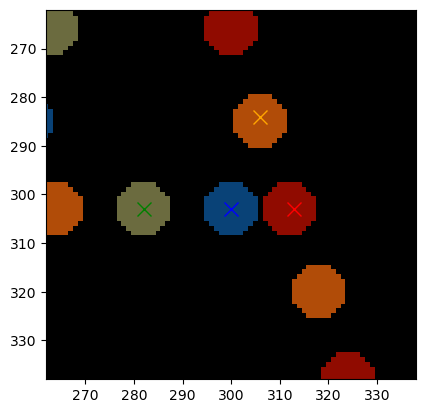

In [37]:
# plot the reconstructions at specific beads

HSI_data = np.reshape(xcal, [-1,dim0])
# HSI_data = np.reshape(np.transpose(xk_orig, (1,2,0)), [-1,dim0])
false_color = sdc.HSI2RGB_jax(wavelengths, HSI_data ,dim2, dim1, 65, False)
plt.imshow(false_color**.8)
# place an x on the bead
yx1 = (3,0)
yx2 = (3,13)
yx3 = (-16,6)
yx4 = (3,-18)
pixavg = 5

# compute the index in the original xcal datacuve
ind1 = (int(yx1[0]+center_y), int(yx1[1]+center_x))
ind2 = (int(yx2[0]+center_y), int(yx2[1]+center_x))
ind3 = (int(yx3[0]+center_y), int(yx3[1]+center_x))
ind4 = (int(yx4[0]+center_y), int(yx4[1]+center_x))
print(ind1, ind2, ind3, ind4)

plt.plot(ind1[1], ind1[0], 'x', color = 'blue', markersize = 10)
plt.plot(ind2[1], ind2[0], 'x', color = 'red', markersize = 10)
plt.plot(ind3[1], ind3[0], 'x', color = 'orange', markersize = 10)
plt.plot(ind4[1], ind4[0], 'x', color = 'green', markersize = 10)
plt.xlim(center_x-zoom_width, center_x+zoom_width)
plt.ylim( center_y+zoom_width, center_y-zoom_width,)
plt.show()

(303, 300) (303, 313) (284, 306) (303, 282)


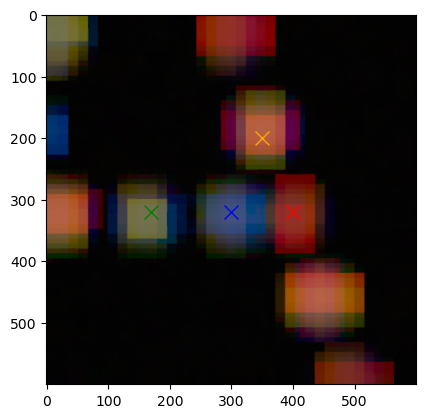

In [48]:
HSI_data = np.reshape(np.transpose(xk_mag, (1,2,0)), [-1,dim0])
false_color = sdc.HSI2RGB_jax(wavelengths, HSI_data ,dim2, dim1, 65, False)
plt.imshow(false_color**.8)

# place an x on the bead
yx1_mag = (20,0)
yx2_mag = (20,100)
yx3_mag = (-100,50)
yx4_mag = (20,-130)
pixavg = 5

# compute the index in the original xcal datacuve
ind1_mag = (int(yx1_mag[0]+center_y), int(yx1_mag[1]+center_x))
ind2_mag = (int(yx2_mag[0]+center_y), int(yx2_mag[1]+center_x))
ind3_mag = (int(yx3_mag[0]+center_y), int(yx3_mag[1]+center_x))
ind4_mag = (int(yx4_mag[0]+center_y), int(yx4_mag[1]+center_x))
print(ind1, ind2, ind3, ind4)

plt.plot(ind1_mag[1], ind1_mag[0], 'x', color = 'blue', markersize = 10)
plt.plot(ind2_mag[1], ind2_mag[0], 'x', color = 'red', markersize = 10)
plt.plot(ind3_mag[1], ind3_mag[0], 'x', color = 'orange', markersize = 10)
plt.plot(ind4_mag[1], ind4_mag[0], 'x', color = 'green', markersize = 10)
# plt.xlim(center_x-zoom_width, center_x+zoom_width)
# plt.ylim( center_y+zoom_width, center_y-zoom_width,)
plt.show()

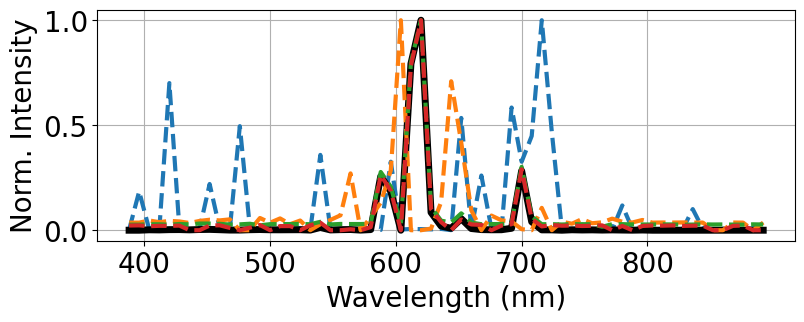

In [58]:
bead_ind = ind2# select between ind and ind2 and ind3for different beads
bead_ind_mag = ind2_mag
plt.figure(figsize=(9,3))

xk = xk_orig
pixavg2 = xk[:,bead_ind[0]-pixavg:bead_ind[0]+pixavg, bead_ind[1]-pixavg:bead_ind[1]+pixavg]
spectra = np.mean(pixavg2, axis=(1,2))
spectra = spectra/np.max(spectra)
plt.plot(wavelengths, spectra, label = 'orig', color = 'tab:blue', linestyle = 'dashed', linewidth = 3)

pixavg2 = xcal[bead_ind[0]-pixavg:bead_ind[0]+pixavg, bead_ind[1]-pixavg:bead_ind[1]+pixavg,:]
spectra = np.mean(pixavg2, axis=(0,1))
spectra = spectra/np.max(spectra)
plt.plot(wavelengths, spectra, color = 'black', linestyle = 'solid', label = 'ground truth', linewidth = 5)

xk = xk_stack[1]
pixavg2 = xk[:,bead_ind[0]-pixavg:bead_ind[0]+pixavg, bead_ind[1]-pixavg:bead_ind[1]+pixavg]
spectra = np.mean(pixavg2, axis=(1,2))
spectra = spectra/np.max(spectra)
plt.plot(wavelengths, spectra, label = 'blur', color = 'tab:orange', linestyle = 'dashed', linewidth = 3)

xk = xk_mag
pixavg2 = xk[:,bead_ind_mag[0]-pixavg:bead_ind_mag[0]+pixavg, bead_ind_mag[1]-pixavg:bead_ind_mag[1]+pixavg]
spectra = np.mean(pixavg2, axis=(1,2))
spectra = spectra/np.max(spectra)
plt.plot(wavelengths, spectra, label = 'mag', color = 'tab:green', linestyle = 'dashed', linewidth = 3)

xk = xk_stack[0]
pixavg2 = xk[:,bead_ind[0]-pixavg:bead_ind[0]+pixavg, bead_ind[1]-pixavg:bead_ind[1]+pixavg]
spectra = np.mean(pixavg2, axis=(1,2))
spectra = spectra/np.max(spectra)
plt.plot(wavelengths, spectra, label = 'diffuser', color = 'tab:red', linestyle = 'dashed',linewidth = 3)


plt.xlabel('Wavelength (nm)', fontsize = 20)
plt.ylabel('Norm. Intensity', fontsize = 20)
plt.xticks([400, 500, 600, 700, 800], fontsize=20)
plt.yticks([0, 0.5, 1], fontsize=20)
plt.grid(True)
plt.show()


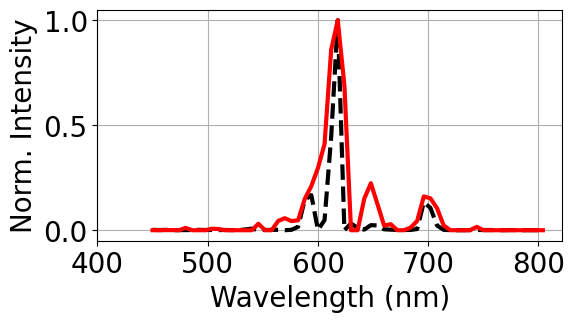

In [56]:
bead_ind = ind1
plt.figure(figsize=(6,3))
pixavg2 = xcal[bead_ind[0]-pixavg:bead_ind[0]+pixavg, bead_ind[1]-pixavg:bead_ind[1]+pixavg,:]
spectra = np.mean(pixavg2, axis=(0,1))
spectra = spectra/np.max(spectra)
plt.plot(wavelengths, spectra, color = 'black', linestyle = '--', label = 'ground truth', linewidth = 3)

xk = xk_stack[0]
pixavg2 = xk[:,bead_ind[0]-pixavg:bead_ind[0]+pixavg, bead_ind[1]-pixavg:bead_ind[1]+pixavg]
spectra = np.mean(pixavg2, axis=(1,2))
spectra = spectra/np.max(spectra)
plt.plot(wavelengths, spectra, label='diffuser', color='r', linewidth=3)

# plt.legend()
plt.xlabel('Wavelength (nm)', fontsize = 20)
plt.ylabel('Norm. Intensity', fontsize = 20)
plt.xticks([400, 500, 600, 700, 800], fontsize=20)
plt.yticks([0, 0.5, 1], fontsize=20)
plt.grid(True)
plt.show()


(303, 300)


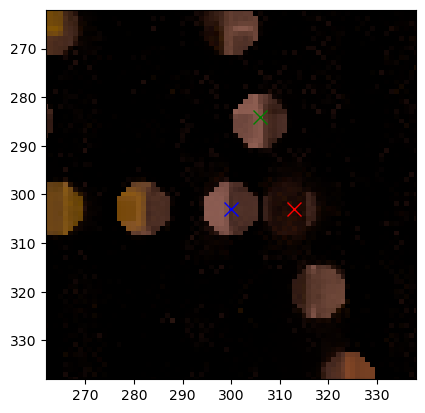

In [34]:
# look into how to get spectra from the bead in delta image

xk = xk_stack[1]
HSI_data = np.reshape(np.transpose(xk, (1,2,0)), [-1,dim0])
false_color = sdc.HSI2RGB_jax(wavelengths, HSI_data ,dim2, dim1, 65, False)
gt_zoom = false_color[center_x-zoom_width:center_x+zoom_width, center_y-zoom_width:center_y+zoom_width]
plt.imshow(gt_zoom**.8)
# place an x on the bead
yx = (3,0)
yx2 = (3,13)
yx3 = (-16,6)
pixavg = 3

# compute the index in the original xcal datacuve
ind = (int(yx[0]+center_y), int(yx[1]+center_x))
ind2 = (int(yx2[0]+center_y), int(yx2[1]+center_x))
ind3 = (int(yx3[0]+center_y), int(yx3[1]+center_x))
print(ind)

plt.imshow(false_color**0.8)
plt.plot(ind[1], ind[0], 'x', color = 'blue', markersize = 10)
plt.plot(ind2[1], ind2[0], 'x', color = 'red', markersize = 10)
plt.plot(ind3[1], ind3[0], 'x', color = 'green', markersize = 10)
plt.xlim(center_x-zoom_width, center_x+zoom_width)
plt.ylim( center_y+zoom_width, center_y-zoom_width,)
plt.show()

## Optional - do the reconstructions within the notebook

0


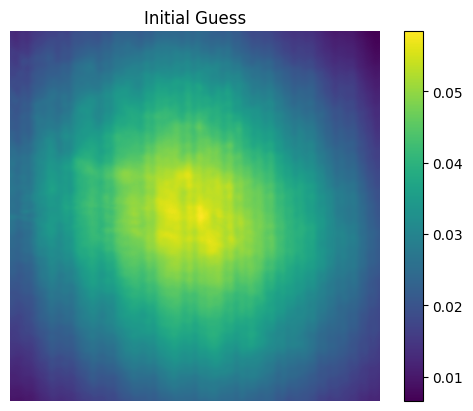

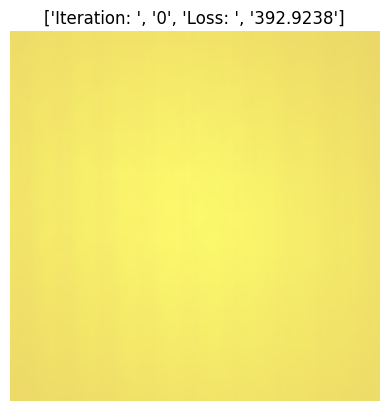

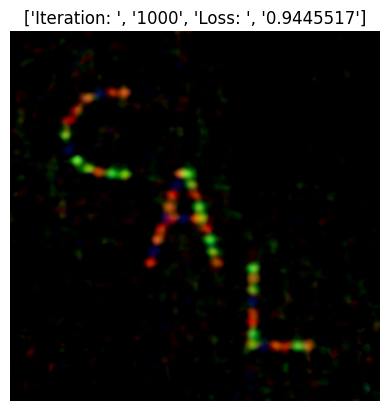

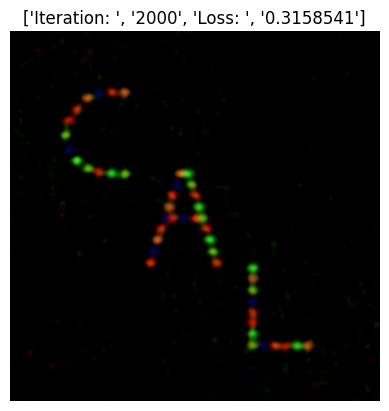

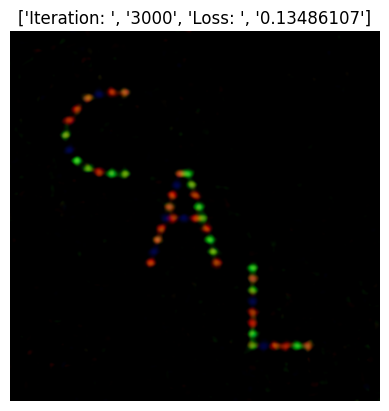

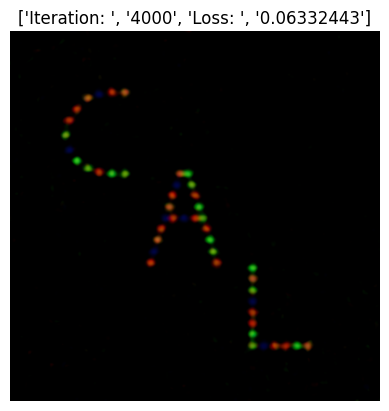

1


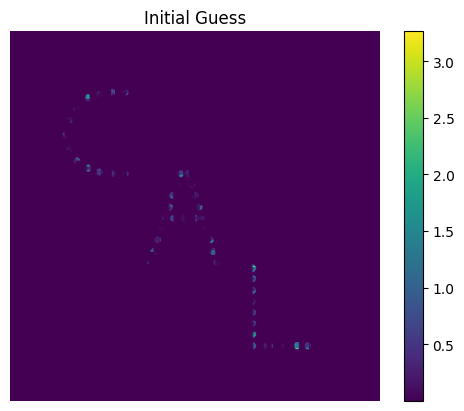

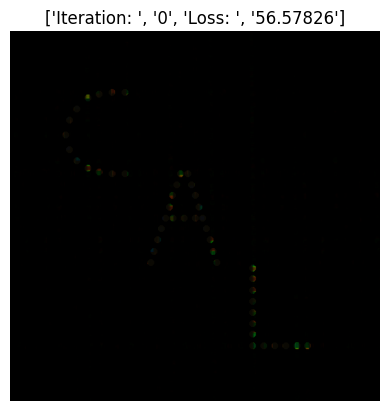

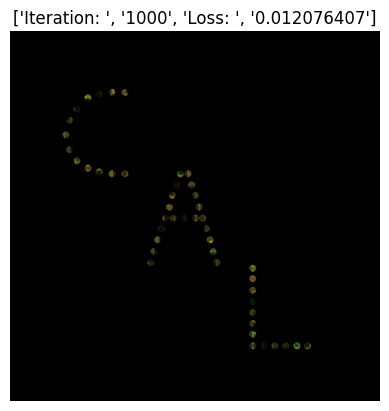

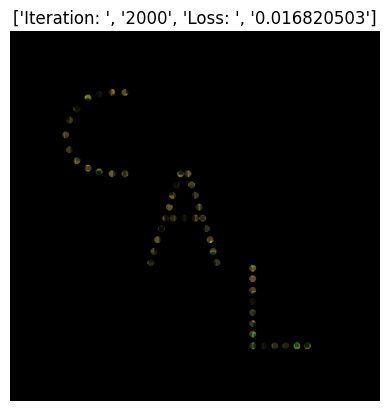

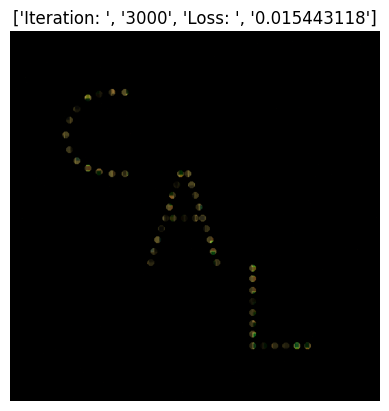

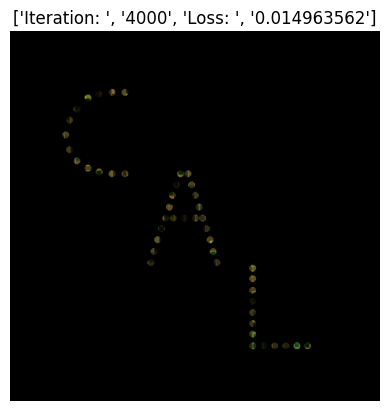

2


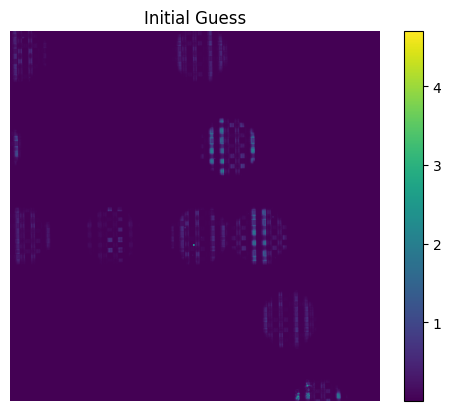

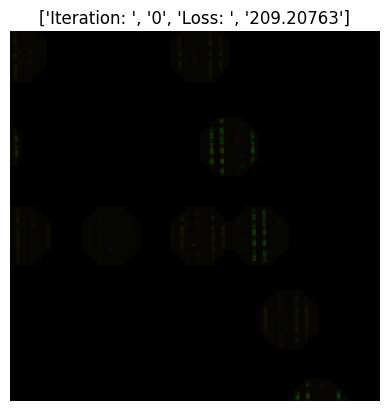

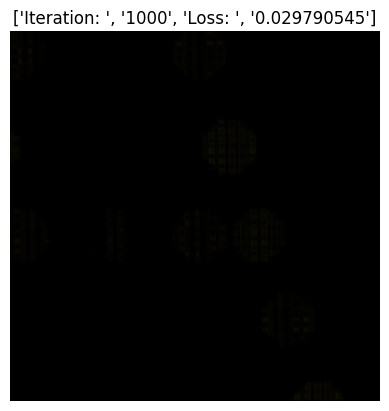

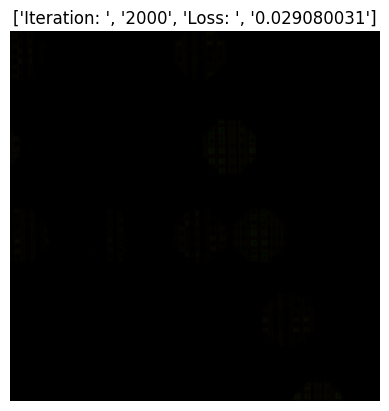

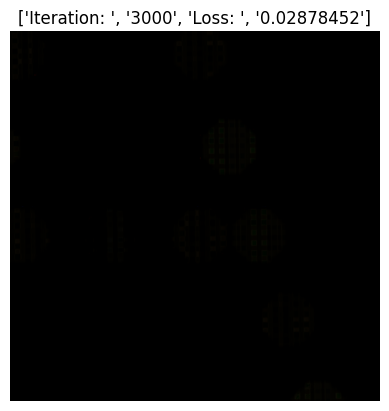

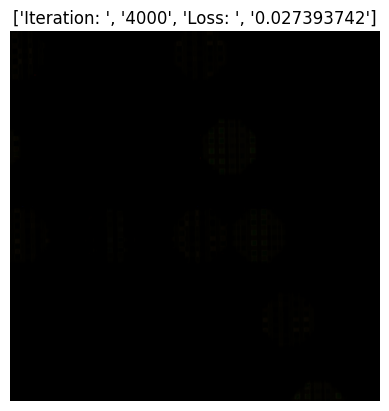

3


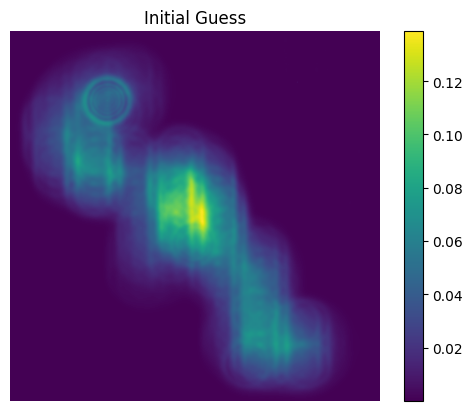

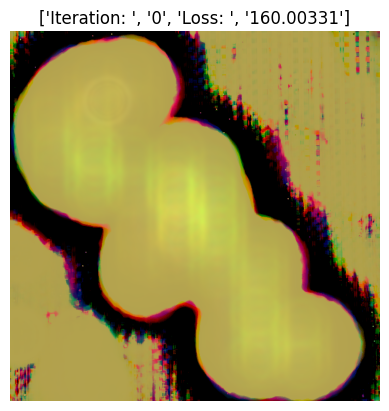

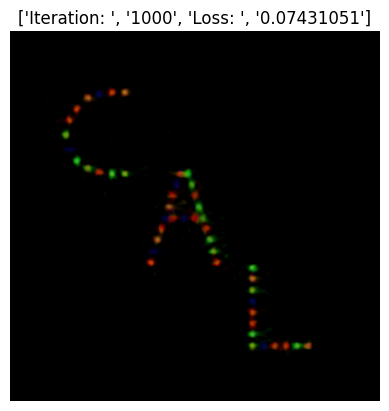

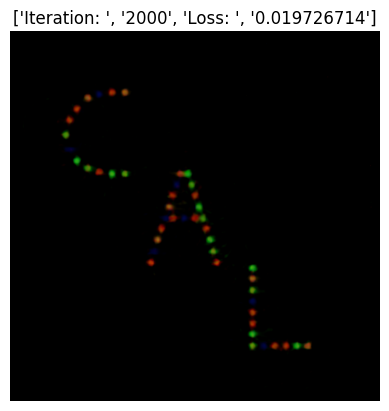

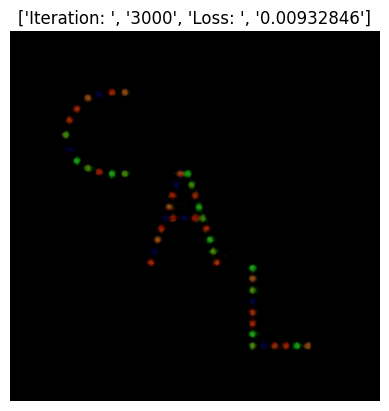

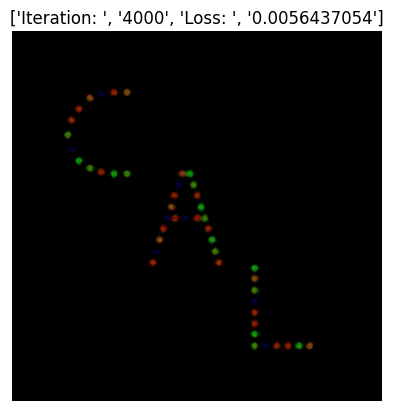

4


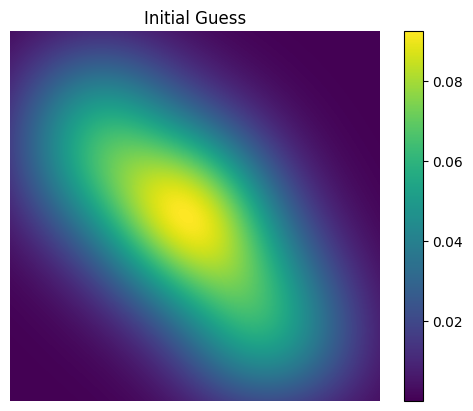

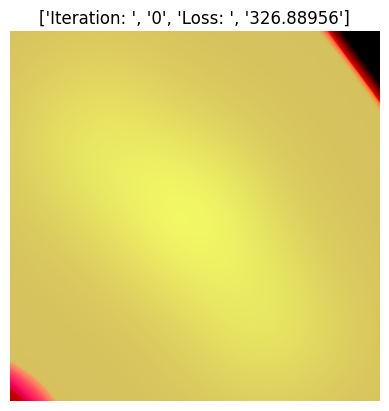

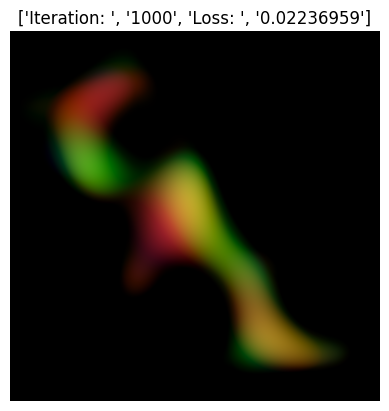

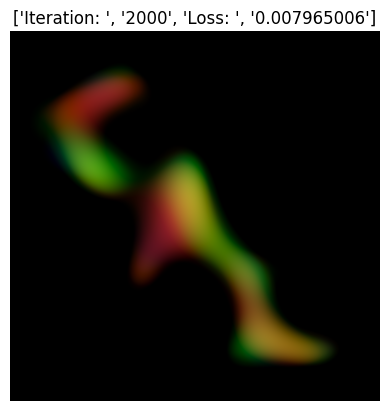

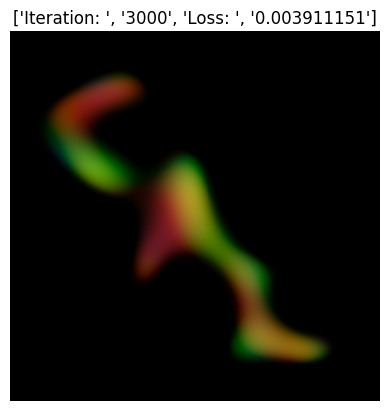

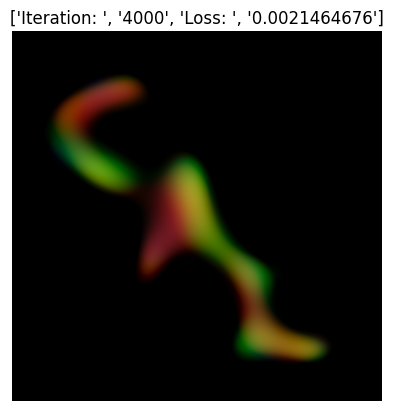

In [37]:
# do recon on diffuser measurement
# define the optimizer
kmax = 5000
kprint = 1000 #show halfway
step_size = 1e-2
thr = 0 #6e-5 #3e-6 is ok
xytv =  0 #1e-6 #1e-4 is big
lamtv = 0#  2e-6 #2e-6 is ok
optimizer = optax.adam(learning_rate=step_size)

# define a function to calculate the gradient and return the loss
loss_and_grad = jax.jit(jax.value_and_grad(sdc.loss_func, (0)))
# initialize the reconstruction
xk_stack = [np.zeros_like(x) for l in range(len(meas_stack))]

for k0 in range(len(meas_stack)):
    print(k0)
    meas = meas_stack[k0]
    psf = psf_stack[k0]
    hpad = jnp.asarray(sdc.pad(torch.Tensor(psf)))
    hfftpad = jnp.fft.fft2(hpad)[None, ...]
    m = jnp.asarray(spectral_filter)
    meas = jnp.asarray(meas/np.amax(meas))

    padding = ((0,0,0),(np.ceil(m.shape[1]/2).astype(int),np.floor(m.shape[1]/2).astype(int),0),(np.ceil(m.shape[2]/2).astype(int),np.floor(m.shape[2]/2).astype(int),0))
    # calculate the adjoint
    xk = sdc.jax_adjoint_model(meas, m, hfftpad, padding)
    # Initialize optimizer state
    opt_state = optimizer.init(xk)  
    plt.figure()
    plt.imshow(np.sum(xk,axis=0))
    plt.axis('off')
    plt.colorbar()
    plt.title('Initial Guess')
    plt.show()

    for k in range(kmax):
        loss, grad = loss_and_grad(xk, meas, m, hfftpad, thr, xytv, lamtv)
        updates, opt_state = optimizer.update(grad, opt_state)
        updates = jnp.nan_to_num(updates)
        # break
        xk = optax.apply_updates(xk, updates)
        xk = jnp.clip(xk, 0, None)
        if k%kprint == 0:
            HSI_data = np.reshape(np.transpose(xk, (1,2,0)), [-1,dim0])
            false_color = sdc_np.HSI2RGB(wavelengths, HSI_data ,dim1,dim2, 75, False)
            plt.figure()
            plt.imshow(false_color**1.8)
            plt.axis('off')
            plt.title(['Iteration: ', str(k), 'Loss: ', str(loss)])
            # plt.colorbar()
            plt.show()
    # save the reconstruction
    xk_stack[k0] = xk


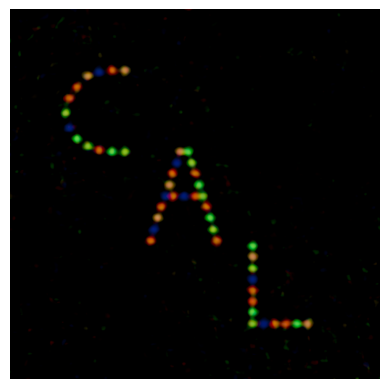

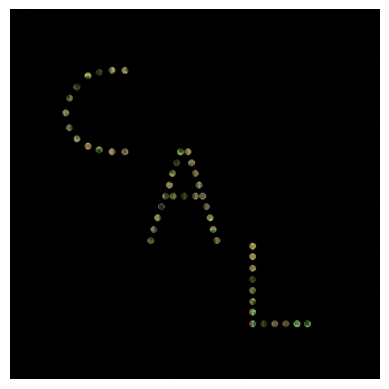

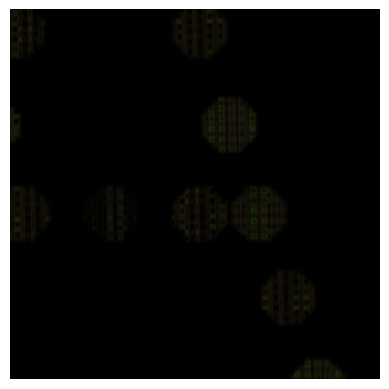

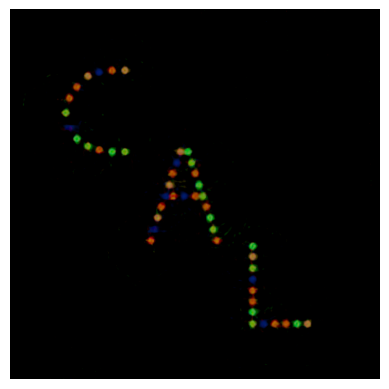

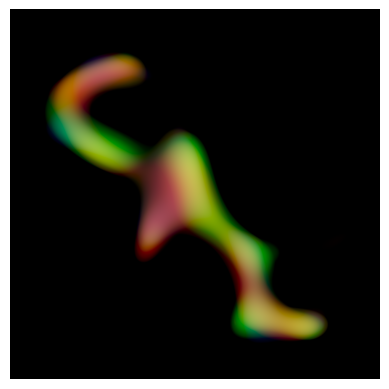

In [38]:
# plot final result. 
for k0 in xk_stack:
    HSI_data = np.reshape(np.transpose(k0, (1,2,0)), [-1,dim0])
    false_color = sdc_np.HSI2RGB(wavelengths, HSI_data ,dim1,dim2, 75, False)
    plt.figure()
    plt.imshow(false_color**1)
    plt.axis('off')
    # plt.colorbar()

In [184]:

# # Create a dictionary
# x_dict = {}

# x_dict['x_mag'] = x_mag
# x_dict['x_blur'] = x_blur
# x_dict['x_delta'] = x_delta
# x_dict['x_diffuser'] = x_diffuser
# x_dict['x_gt'] = x

# import pickle
# # Specify the file path where you want to save the dictionary
# file_path = './Figures/calbeadsim/x_recons.pkl'

# # Save the dictionary to the file
# with open(file_path, 'wb') as file:
#     pickle.dump(x_dict, file)
# # Print the dictionary
# print(x_dict)

{'x_mag': Array([[[3.4455545e-02, 3.5274789e-02, 7.5399995e-02, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [3.4754336e-02, 3.5522029e-02, 7.4589446e-02, ...,
         0.0000000e+00, 0.0000000e+00, 9.4611907e-10],
        [3.3117846e-02, 3.2262791e-02, 6.7715615e-02, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[3.4463752e-02, 3.5255618e-02, 7.5364724e-02, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [3.4742568e-02, 3.5507713e-02, 7.4567370e-02, ...,
         0.0000000e+00, 0.0000000e+00, 2.2783935e-09],
        [3.3104122e-02, 3.2249074e-02, 6.7699686e-02, ...,
    

In [ ]:
## try to add more noise to defocus psf?
